In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

/tmp/ipykernel_218706/1256517549.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import numpy as np
from tqdm import tqdm as tqdm
#from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os
import optparse
import os.path as osp
import math
import torch_geometric
import torch
import sys
from torch_geometric.data import Data
import glob
from datetime import datetime
import random


from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import torch.jit as jit

In [3]:
# tt=torch.load("/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/ntup_pho_18082024/data_499.pt")
# np.unique(tt[0].clus2d_feat[:,5])

### set seed for reproducibility

In [4]:
seed = 42

In [5]:
torch.manual_seed(seed)
#torch.use_deterministic_algorithms(True) # not good: this makes the training break
random.seed(seed)

### tensors features

In [6]:
#########################################
# clus2d_feats = np.stack((ak.to_numpy(sel_clusters[ts].position_x),
#                          ak.to_numpy(sel_clusters[ts].position_y),
#                          ak.to_numpy(sel_clusters[ts].position_z),
#                          ak.to_numpy(sel_clusters[ts].energy),
#                          ak.to_numpy(sel_clusters[ts].cluster_time),
#                          ak.to_numpy(sel_clusters[ts].cluster_layer_id))).T

#                     #print(clus2d_feats.shape)
# clus3d_feats = np.stack((sel_tseta[ts][0],
#                          sel_tsphi[ts][0],
#                          sel_tsen[ts][0],
#                          sel_tst[ts][0],
#                          min(ak.to_numpy(sel_clusters[ts].cluster_layer_id)),
#                          max(ak.to_numpy(sel_clusters[ts].cluster_layer_id)))).T
# gun_feats = np.stack((sel_cpeta[ts][0],
#                       sel_cpphi[ts][0],
#                       sel_cpen[ts][0],
#                       sel_cpent[ts][0], 
#                       sel_ratem[ts][0]    trk_em/ sim_em
#                       sel_rattot[ts][0]   trk/sim
#                        )).T
########################################

### Load input data

In [7]:
from torch.utils.data import Dataset

class ClassificationDataset(Dataset):
    def __init__(self, datapath, numLC, feats, signal, ispi, abz):
        self.datapath_ = datapath
        self.numLC_ = numLC
        self.signal_ = signal
        self.ispi_ = ispi
        self.abz_ = abz
        self.feats_ = feats
        self.process = self.load_datafiles(self.datapath_)
        self.data = torch.stack(self.process[0],dim=0)
        self.labels = torch.stack(self.process[1],dim=0)
        self.masks = torch.stack(self.process[2],dim=0)
        self.info3d = torch.stack(self.process[3],dim=0)
        self.infogun = torch.stack(self.process[4],dim=0)


    def load_datafiles(self, filepath) :
        "filepath of the form /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_DATA/ntup_pho_frac0p8/ "
        print("processing files from:",filepath)
        filelist = [filen for filen in glob.glob(filepath+'data*.pt')]
        output_tensor_list = []
        label = []
        mask_tensor_list = []
        info3d_tensor_list = []
        infogun_tensor_list = []
        
        ctot = 0
        cll = 0
        
        
        for i in tqdm(filelist):
            if (len(label)>50000):
                    break
            
            for filei in torch.load(i) :
                ctot += 1
                #print(filei.gun_feat)
                passpi = False
                passpu = False
                nlay = len(np.unique(filei.clus2d_feat[:,5]))
                ratrec_true = (filei.clus3d_feat[2]/filei.gun_feat[:,3]).item()

                if (self.signal_):
#                    if (nlay < 13) :
                    if (ratrec_true < 0.7):
                        cll += 1                        
                        continue
                else:
                    feat2da = filei.clus2d_feat
                    fracen26 = torch.sum(feat2da[feat2da[:,5] <=26][:,3])/torch.sum(feat2da[:,3])
                    if self.ispi_:
                        #if (nlay > 10)and(fracen26 > 0.7)and(min(feat2da[:,5]) < 15) :
                        passpi = True
                        if not(passpi):
                            cll += 1
                            continue
                        #print("self.ispi_ & nlay < 10 & fracen26< 0.7", self.ispi_, nlay , fracen26)
                    else:
                        #if ((nlay < 10)and(fracen26 < 0.7))or ((nlay > 10)and(fracen26 < 0.7)) or ((nlay < 10)and(fracen26 > 0.7)):
                        #if not((nlay > 10)and(fracen26 > 0.7)and(min(feat2da[:,5]) < 15)):
                        if not((nlay > 10)and(fracen26 > 0.6)and(min(feat2da[:,5]) < 15)and((np.average(filei.clus2d_feat[:,2], weights=filei.clus2d_feat[:,3])) < 360)):
                            passpu = True
                        else:
                            pass
                            #print("self.ispi_ & nlay < 10 & fracen26< 0.7", self.ispi_, nlay, fracen26)
                        if not(passpu):
                            cll += 1
                            continue
                        #print("self.ispi_ & nlay < 10 & fracen26< 0.7", self.ispi_, nlay, fracen26)
               
                
                
                
                
                
                optensor = self.transform_data(filei.clus2d_feat, self.numLC_)
                output_tensor_list.append(optensor[0])
                mask_tensor_list.append(optensor[1])
                info3d_tensor_list.append(filei.clus3d_feat[[0,1,2,4,5]])
                infogun_tensor_list.append(filei.gun_feat)
                if self.signal_:
                    label.append(torch.ones(1,dtype=torch.double))
                else:
                    label.append(torch.zeros(1,dtype=torch.double))
         
        
        print ("nskipped | ntotal:",cll," | ",ctot)
        return output_tensor_list, label, mask_tensor_list, info3d_tensor_list, infogun_tensor_list
                
    def transform_data(self, tensor, nLC) :            

        #feats = [0,1,2,5]
        target = torch.zeros(nLC, len(self.feats_))
        mask0 = torch.ones(nLC)
        source = tensor[:nLC,self.feats_]
        mask1 = torch.zeros(source.shape[0])
        if self.abz_:
            source[:,2] = np.abs(source[:,2])
        target[:source.shape[0], :] = source
        #source = source.T
        mask0[:source.shape[0]] = mask1
        mask0 
        #print(mask0)
        return target, mask0 > 0
    
        
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx): 
        return self.data[idx], self.labels[idx], self.masks[idx], self.info3d[idx], self.infogun[idx]

#### Photon dataset (energy spread: 10-1000 GeV)

In [8]:
pho_path = "/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rmin_pho_30072024/"
pho_dataset = ClassificationDataset(pho_path, 150, [0,1,5,3], True, False, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rmin_pho_30072024/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 31.67it/s]


nskipped | ntotal: 119  |  50000


#### Pion dataset: pion sample from where high energy early showering pions are removed

In [9]:
hizpu_path = "/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2R0p9_pi_30072024/"
hizpu_dataset = ClassificationDataset(hizpu_path, 150, [0,1,5,3], False, False, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2R0p9_pi_30072024/


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 484/500 [00:30<00:01, 15.75it/s]


nskipped | ntotal: 20625  |  70628


#### Pion dataset: low energy clusters within CEE + others (no CEE restrictions)

##### low energy pions removing the pi0

In [10]:
lowzpu_path = "/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rno_PUenrich_05082024/"
lowzpu_dataset = ClassificationDataset(lowzpu_path, 150, [0,1,5,3], False, False, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rno_PUenrich_05082024/


 50%|██████████████████████████████████████████████████████████▌                                                          | 3/6 [02:37<02:37, 52.54s/it]


nskipped | ntotal: 228603  |  287365


##### low energy pions with all inside: no skipping of pi0

In [11]:
unbiased_dataset = ClassificationDataset(lowzpu_path, 150, [0,1,5,3], False, True, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rno_PUenrich_05082024/


 17%|███████████████████▌                                                                                                 | 1/6 [00:52<04:24, 52.98s/it]


nskipped | ntotal: 0  |  95549


In [12]:
print("lenpho:",len(pho_dataset), " lenhizpu:",len(hizpu_dataset), " lenlozpu:",len(lowzpu_dataset), " lenunbias:",len(unbiased_dataset))

lenpho: 49881  lenhizpu: 50003  lenlozpu: 58762  lenunbias: 95549


### Define training and testing datasets

In [13]:
nphos = len(pho_dataset)
idxstotsamp = np.arange(nphos)

#### ATTENTION!
## for training up to number 7, then we changed it for training number 8
#CEE_dataset = unbiased_dataset # for training up to number 7; comment for training number 8 inference
CEE_dataset = lowzpu_dataset # for training number 8


### DEFINE Background COMPOSITION
hizpusel = torch.utils.data.Subset(hizpu_dataset, idxstotsamp[:int(0.3*nphos)])
lowzpusel = torch.utils.data.Subset(CEE_dataset, idxstotsamp[:int(0.7*nphos)])
#npusel = len(pho_dataset) - len(pisel)
#pusel = torch.utils.data.Subset(pu_dataset, idxstotsamp[:int(npusel)])

combdataset = torch.utils.data.ConcatDataset([pho_dataset, hizpusel, lowzpusel])

nsamp = len(combdataset)

idxs = np.arange(nsamp)
np.random.shuffle(idxs)
tridx = idxs[:int(0.8*nsamp)]
tsidx = idxs[int(0.8*nsamp):nsamp]
trdata = torch.utils.data.Subset(combdataset, tridx)
tsdata = torch.utils.data.Subset(combdataset, tsidx)

ntrainbatch = 600
## load train and test dataset
trainloader = torch.utils.data.DataLoader(trdata, batch_size=ntrainbatch ,shuffle=True)#, num_workers=2)
testloader = torch.utils.data.DataLoader(tsdata, batch_size=ntrainbatch,shuffle=True)#, num_workers=2)
## load all data, for plots later
totalloader = torch.utils.data.DataLoader(combdataset, batch_size=ntrainbatch,shuffle=True)#, num_workers=2)
## load unbiased dataset, for plots and inference later
unbiasloader = torch.utils.data.DataLoader(unbiased_dataset, batch_size=ntrainbatch,shuffle=True)


print("total samples") 
print("npho    ",len(pho_dataset))
print("nhizpu  ",len(hizpusel))
print("nlozpu  ",len(lowzpusel))
print("nTOT    ",nsamp)
print("nunbias ",len(unbiased_dataset))
print("N_train, N_test:",len(trdata),",",len(tsdata))

total samples
npho     49881
nhizpu   14964
nlozpu   34916
nTOT     99761
nunbias  95549
N_train, N_test: 79808 , 19953


### Define model

In [14]:
## Define model
## refer https://github.com/ludovicobuizza/HAR-Transformer/blob/main/src/transformer/transformer.py for batchnorm
import torch.nn as nn
import torch.nn.functional as F

class MHA_model(jit.ScriptModule):
    

    def __init__(
        self,
        input_dim = 6,
        dim_emb = 64,
        n_heads = 16,
        num_enclayers = 6,
        dim_feedforward = 64,
        n_seq = 150,
        output_dim = 2,
        norm=torch.tensor([1./100., 1./100., 1./100., 1./100.]),
    ):
        
        super(MHA_model, self).__init__()
        self.datanorm = nn.Parameter(norm, requires_grad=False) 
        self.emb_inp = nn.Sequential(
            nn.Linear(input_dim, dim_emb),
            nn.Dropout(0.1),
            nn.ELU(),
            #nn.LeakyReLU(negative_slope=0.4),
            nn.Linear(dim_emb, dim_emb),
            nn.Dropout(0.1),
#            nn.LeakyReLU(negative_slope=0.4),
#            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ELU(),
            #nn.LeakyReLU(negative_slope=0.4),
        )
        
#        self.emb_inp =  nn.Linear(input_dim, dim_emb)      
        encoder_layer = nn.TransformerEncoderLayer(
                dim_emb,
                n_heads,
                dim_feedforward,
                dropout = 0.2,
                batch_first= True,
                activation=nn.ELU(),  #nn.LeakyReLU(negative_slope=0.4),
            )
        
        
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_enclayers)
        
        self.output_layer = nn.Sequential(nn.Linear(n_seq*dim_emb + 5, dim_emb//2),
                                    
                                    #nn.LeakyReLU(negative_slope=0.4),
                                    nn.Dropout(0.3),
                                    nn.ELU(),
                                    #nn.Softplus(),
                                    nn.Linear(dim_emb//2, dim_emb//2),#added
                                    nn.Dropout(0.3),
                                    nn.ELU(),
                                    nn.Linear(dim_emb//2, dim_emb//2),#added
                                    nn.Dropout(0.3),
                                    nn.ELU(),
                                    #nn.Softplus(),
                                    nn.Linear(dim_emb//2, output_dim)
                                   )
    
    
    @jit.script_method
    def forward(self, X, mask, info3d) :
        
        
        #project input to dim_emb dimensional space
        X = self.datanorm*X
        inp = self.emb_inp(X) #* math.sqrt(self.dim_embed)
        
        output = self.transformer_encoder(inp, src_key_padding_mask=mask)  # (batch, seq, feat)
        output = output.reshape(output.shape[0], -1)  # (batch, seq * feat)
        output = torch.concat((output,info3d), dim = -1)
        output = self.output_layer(output)  # (batch, num_classes)

        return F.log_softmax(output, dim=-1)

### define training and testing functions

In [15]:
### define training and testing functions
#from lr_modulation import *
device = torch.device('cuda:1')#('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
#model = NetCNN().to(float) ### change to NetDNN().to(float) for DNN
#model = model.to(device)


model = MHA_model(n_seq=150,
        input_dim = 4,
        dim_emb = 16,#32
        n_heads = 16,
        num_enclayers = 6,#4
        dim_feedforward = 64,
        output_dim = 2)


model = model.to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
#scheduler = CyclicLRWithRestarts(optimizer, ntrainbatch, epoch_size, restart_period=10, t_mult=1.2, policy="cosine")
#scheduler = CyclicLRWithRestarts(optimizer, 200, 200, restart_period=30, t_mult=1.2, policy="cosine")
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,50)
#lossfunction = nn.BCELoss()



def train(epoch):
    model.train()
    torch.cuda.empty_cache()
    loss = []
    true_preds, num_preds = 0., 0.
    iters = len(trainloader)
    cc = 0
    for data in tqdm(trainloader):  ### change to loaderDNN for DNN
            #datax, label = data[0].to(device), data[1].to(device)
            datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
            label = label.to(torch.long).squeeze()
            optimizer.zero_grad()
            result = model(datax, masks, info3d)
            #print(result)
            
            #print(label)
            #print(result.dtype)
            #lossc = lossfunction(result, label)
            lossc = F.nll_loss(result, label)
            
            loss.append(lossc.item()) 
            lossc.backward()
            optimizer.step()
            scheduler.step(epoch + cc / iters)
            cc += 1
            pred_labels = torch.argmax(result.cpu(), dim=-1) 
            true_preds += (pred_labels == label.cpu()).sum()
            num_preds += label.shape[0]
            
    acc = true_preds / num_preds
    #print( 'batches for train:',len(loss)) 
    print('train loss:',np.mean(np.array(loss)))
    print('train acc:',np.mean(np.array(acc)))
    return np.mean(np.array(loss)), np.array(acc)


def test(epoch):
    model.eval()
    loss = []
    true_preds, num_preds = 0., 0.
    for data in tqdm(testloader): ### change to loaderDNN for DNN
            datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)            
            label = label.to(torch.long).squeeze()
            result = model(datax, masks, info3d)
            lossc = F.nll_loss(result, label)
            loss.append(lossc.item())
            
            pred_labels = torch.argmax(result.cpu(), dim=-1) 
            true_preds += (pred_labels == label.cpu()).sum()
            num_preds += label.shape[0]
            
            
    acc = true_preds / num_preds
    #print( 'batches for train:',len(loss)) 
    print('test loss:',np.mean(np.array(loss)))
    print('test acc:',np.mean(np.array(acc)))
    return np.mean(np.array(loss)), np.array(acc)

/opt/exp_soft/vo.gridcl.fr/software/torch/2.0.1/py311-cuda117/lib/python3.11/site-packages/torch/jit/_recursive.py:266: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn("'{}' was found in ScriptModule constants, "


## Inference with model of best accuracy checkpoint

### Load best accuracy checkpoint and define model

In [16]:
### REMEMBER: specify the correct input model

#out_dir = '20250226_225333_checkpoints' # training 4
#out_dir = '20250227_190925_checkpoints' # training 6
#out_dir = '20250227_235925_checkpoints' # training 7
out_dir = '20250306_181358_checkpoints' # training 8

device = torch.device('cuda:1')#('cuda' if torch.cuda.is_available() else 'cpu')
model_load = torch.load(out_dir+"/model_checkpoint_bestacc.pth.tar")
print(out_dir)


model = MHA_model(n_seq=150,
        input_dim = 4,
        dim_emb = 16,#32
        n_heads = 16,
        num_enclayers = 6,#4
        dim_feedforward = 64,
        output_dim = 2)


model.to(device)
model.load_state_dict(model_load["state_dict"])
model.eval()

20250306_181358_checkpoints


MHA_model(
  (emb_inp): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=Dropout)
    (2): RecursiveScriptModule(original_name=ELU)
    (3): RecursiveScriptModule(original_name=Linear)
    (4): RecursiveScriptModule(original_name=Dropout)
    (5): RecursiveScriptModule(original_name=ELU)
  )
  (transformer_encoder): RecursiveScriptModule(
    original_name=TransformerEncoder
    (layers): RecursiveScriptModule(
      original_name=ModuleList
      (0): RecursiveScriptModule(
        original_name=TransformerEncoderLayer
        (self_attn): RecursiveScriptModule(
          original_name=MultiheadAttention
          (out_proj): RecursiveScriptModule(original_name=NonDynamicallyQuantizableLinear)
        )
        (linear1): RecursiveScriptModule(original_name=Linear)
        (dropout): RecursiveScriptModule(original_name=Dropout)
        (linear2): RecursiveScriptModule(original_name=Lin

### Confusion matrix and accuracy on test dataset (testloader)

  6%|██████▊                                                                                                             | 2/34 [00:03<00:48,  1.51s/it]/opt/exp_soft/vo.gridcl.fr/software/torch/2.0.1/py311-cuda117/lib/python3.11/site-packages/torch/nn/modules/module.py:1501: UserWarning: FALLBACK path has been taken inside: runCudaFusionGroup. This is an indication that codegen Failed for some reason.
To debug try disable codegen fallback path via setting the env variable `export PYTORCH_NVFUSER_DISABLE=fallback`
 (Triggered internally at ../third_party/nvfuser/csrc/manager.cpp:335.)
  return forward_call(*args, **kwargs)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.59it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


accuracy: 0.9998496
threshold : 0.99999976


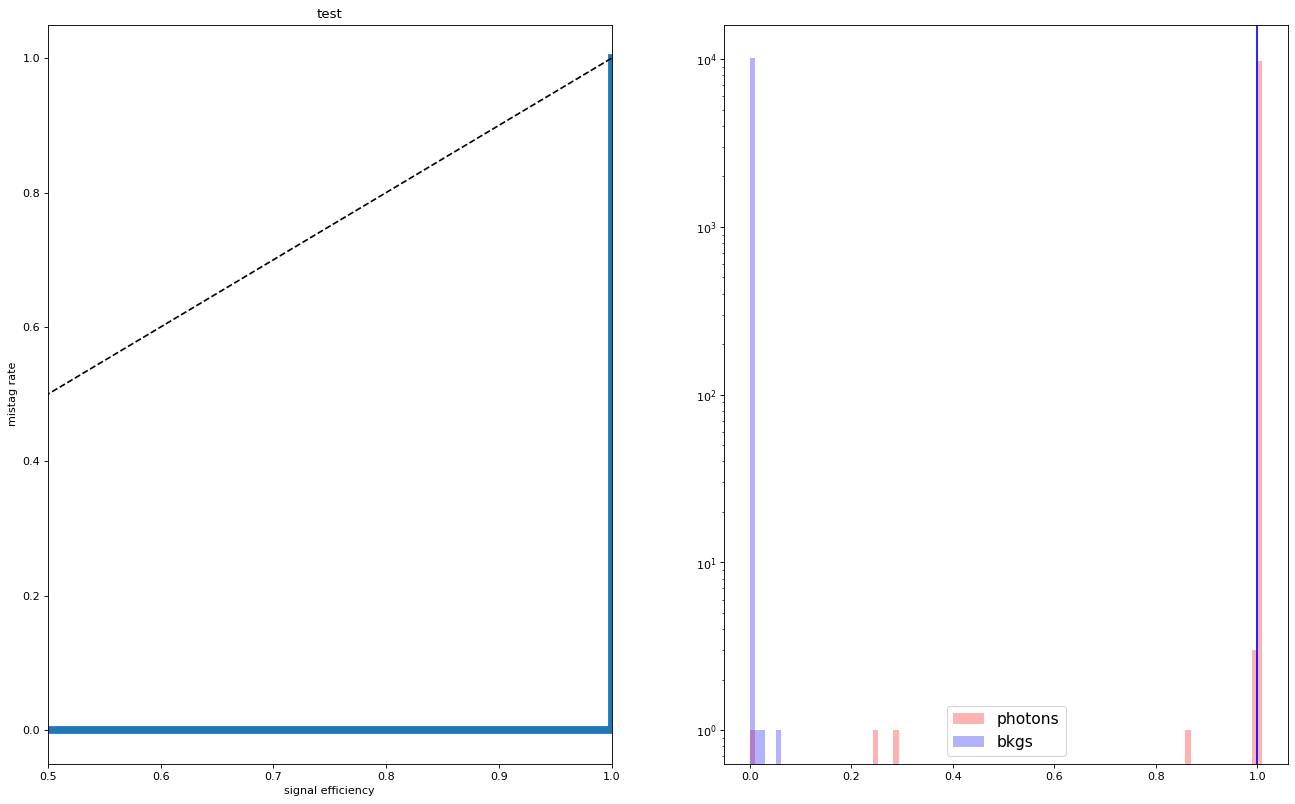

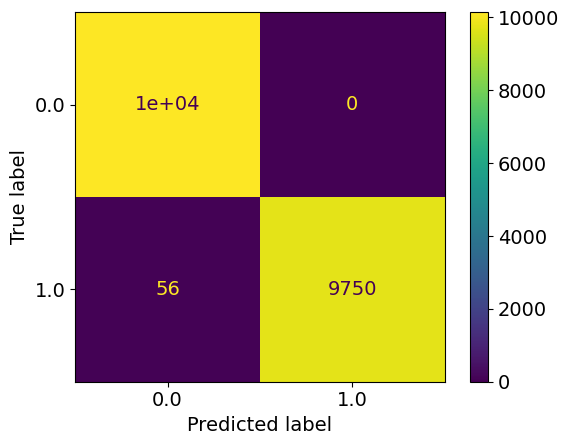

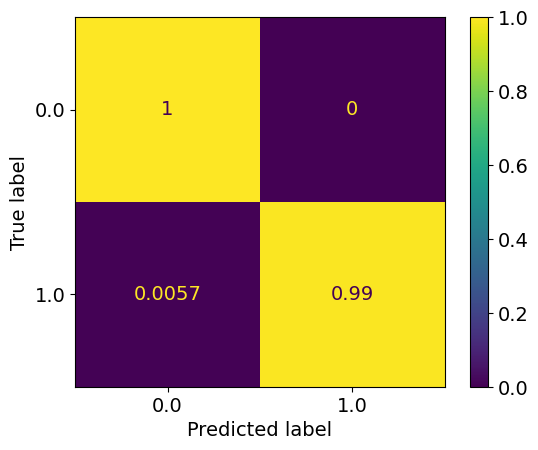

In [17]:
scores = []
trues = []
true_preds, num_preds = 0., 0.
#threshold90 = 0.152
mispredpho = []
mispredbkg = []
for data in tqdm(testloader): ### change to loaderDNN for DNN
    
        datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
        #label = label.to(torch.long).squeeze()
        result = model(datax, masks, info3d)
        op = torch.exp(result)[:,1].detach().cpu().flatten().numpy()
        ip = label.detach().cpu().numpy().flatten()
        scores.append(op)
        trues.append( ip )

######## use the following lines if you want to store mispredicted event indices for plotting  (REMEMBER to set batch_size=1)

#        opt = np.where(np.hstack(op)>threshold90, 1, 0)
#        if (ip == 1)&(opt == 0):
#            mispredpho.append(datax.detach().cpu().numpy())
#        elif (ip == 0)&(opt == 1):
#            mispredbkg.append(datax.detach().cpu().numpy())

        
        
        ######## use the following lines if you want just the overall scores for accuracy etc (Use this when you want to extract threshold and plot confusion matrices)
        
        label = label.to(torch.long).squeeze()
        pred_labels = torch.argmax(result.cpu(), dim=-1) 
        true_preds += (pred_labels == label.cpu()).sum()
        num_preds += label.shape[0]
        
acc = true_preds / num_preds
print("accuracy:",np.mean(np.array(acc)))

########################### this part extracts the threshold value and plots overall confusion matrices

truesa = np.hstack(trues)
scoresa = np.hstack(scores)
fpr, tpr, thresholds = metrics.roc_curve(truesa, scoresa, pos_label=1)
aucv = metrics.auc(fpr, tpr)

tpr90,fpr90,threshold90_test = 0,0,0
for i,j,k in zip(tpr,fpr,thresholds):
    if i >0.995:
        tpr90 = i
        fpr90 = j
        threshold90_test = k
        break
print("threshold :",threshold90_test)
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(20, 12),dpi=80)
plt.rcParams['font.size'] = '14'
### plot AUC
ax0.plot(tpr,fpr, linewidth=7.0, label= "AUC:"+str(round(aucv,3))+" eff:"+str(round(tpr90,3))+" @ bkg rejection rate:"+str(round(1-fpr90,3)))
ax0.set_xlabel("signal efficiency")
ax0.set_ylabel("mistag rate")
ax0.set_xlim([0.5,1])
ax0.plot([0.,1], [0.,1], 'k--')
ax0.title.set_text("test")
plt.legend()
#plt.show()

## plot signal-bkg distribution
ax1.hist(scoresa[truesa == 1],bins=100, range=[0,1.01], label='photons',linewidth=2.0, color="r" , alpha=0.3)
ax1.hist(scoresa[truesa == 0],bins=100, range=[0,1.01], label='bkgs',linewidth=2.0, color="b", alpha=0.3 )
ax1.axvline(threshold90_test,c="b")
plt.yscale("log")
plt.legend()
plt.show()

#ax.text(0.6,0.6,aucv,)
#plt.yscale("log")
#plt.legend()
#plt.show()



### plot confusion matrices
ConfusionMatrixDisplay.from_predictions(truesa, np.where(scoresa>threshold90_test, 1, 0))
plt.show()
ConfusionMatrixDisplay.from_predictions(truesa, np.where(scoresa>threshold90_test, 1, 0), normalize="true")
plt.show()

### Confusion matrix and accuracy on full dataset (totalloader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:12<00:00, 13.84it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


accuracy: 0.9998697
threshold : 0.99999976


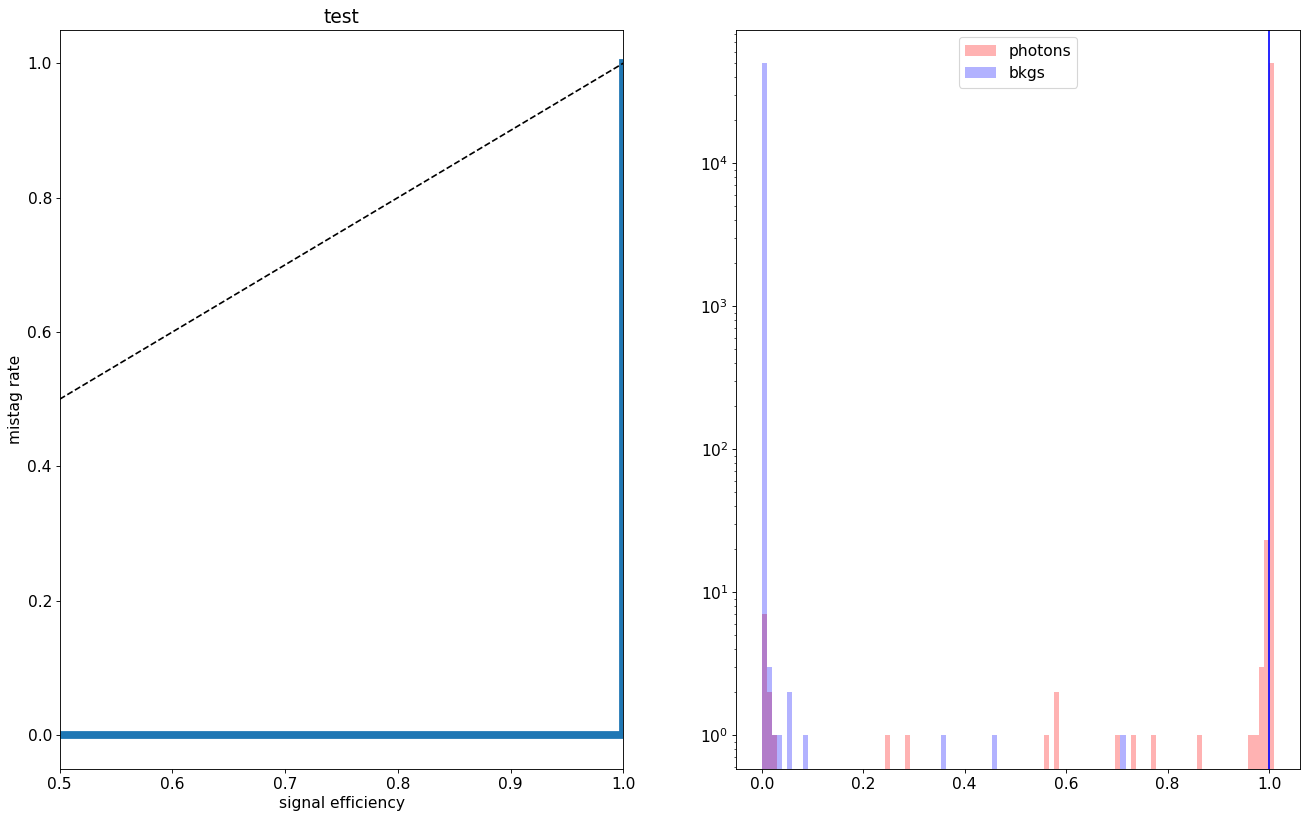

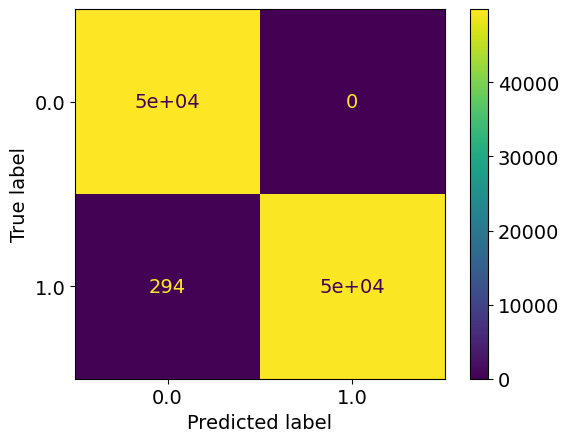

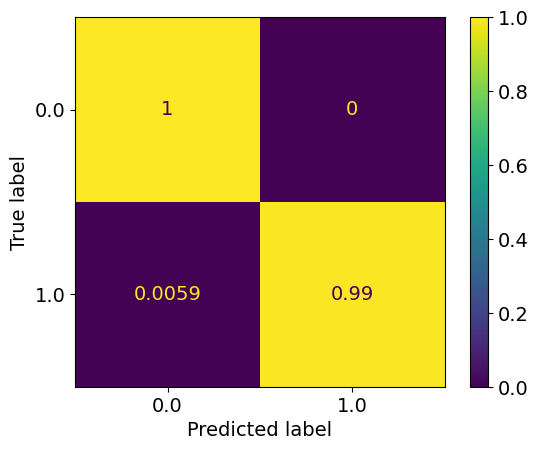

In [18]:
scores = []
trues = []
true_preds, num_preds = 0., 0.
#threshold90 = 0.152
mispredpho = []
mispredbkg = []
for data in tqdm(totalloader): ### change to loaderDNN for DNN
        datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
        #label = label.to(torch.long).squeeze()
        result = model(datax, masks, info3d)
        op = torch.exp(result)[:,1].detach().cpu().flatten().numpy()
        ip = label.detach().cpu().numpy().flatten()
        scores.append(op)
        trues.append( ip )
     
        ######## use the following lines if you want just the overall scores for accuracy etc (Use this when you want to extract threshold and plot confusion matrices)
        
        label = label.to(torch.long).squeeze()
        pred_labels = torch.argmax(result.cpu(), dim=-1) 
        true_preds += (pred_labels == label.cpu()).sum()
        num_preds += label.shape[0]
        
acc = true_preds / num_preds
print("accuracy:",np.mean(np.array(acc)))

########################### this part extracts the threshold value and plots overall confusion matrices

truesa = np.hstack(trues)
scoresa = np.hstack(scores)
fpr, tpr, thresholds = metrics.roc_curve(truesa, scoresa, pos_label=1)
aucv = metrics.auc(fpr, tpr)

tpr90,fpr90,threshold90_tot = 0,0,0
for i,j,k in zip(tpr,fpr,thresholds):
    if i >0.995:
        tpr90 = i
        fpr90 = j
        threshold90_tot = k
        break
print("threshold :",threshold90_tot)
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(20, 12),dpi=80)
plt.rcParams['font.size'] = '14'
### plot AUC
ax0.plot(tpr,fpr, linewidth=7.0, label= "AUC:"+str(round(aucv,3))+" eff:"+str(round(tpr90,3))+" @ bkg rejection rate:"+str(round(1-fpr90,3)))
ax0.set_xlabel("signal efficiency")
ax0.set_ylabel("mistag rate")
ax0.set_xlim([0.5,1])
ax0.plot([0.,1], [0.,1], 'k--')
ax0.title.set_text("test")
plt.legend()
#plt.show()

## plot signal-bkg distribution
ax1.hist(scoresa[truesa == 1],bins=100, range=[0,1.01], label='photons',linewidth=2.0, color="r" , alpha=0.3)
ax1.hist(scoresa[truesa == 0],bins=100, range=[0,1.01], label='bkgs',linewidth=2.0, color="b", alpha=0.3 )
ax1.axvline(threshold90_tot,c="b")
plt.yscale("log")
plt.legend()
plt.show()

#ax.text(0.6,0.6,aucv,)
#plt.yscale("log")
#plt.legend()
#plt.show()



### plot confusion matrices
ConfusionMatrixDisplay.from_predictions(truesa, np.where(scoresa>threshold90_tot, 1, 0))
plt.show()
ConfusionMatrixDisplay.from_predictions(truesa, np.where(scoresa>threshold90_tot, 1, 0), normalize="true")
plt.show()

### Confusion matrix and accuracy on unbiased dataset (unbiasloader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:13<00:00, 11.73it/s]
/opt/exp_soft/llr/python/3.11.6/el7/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


accuracy: 0.6511528
threshold unbias: 0
threshold tot: 0.99999976


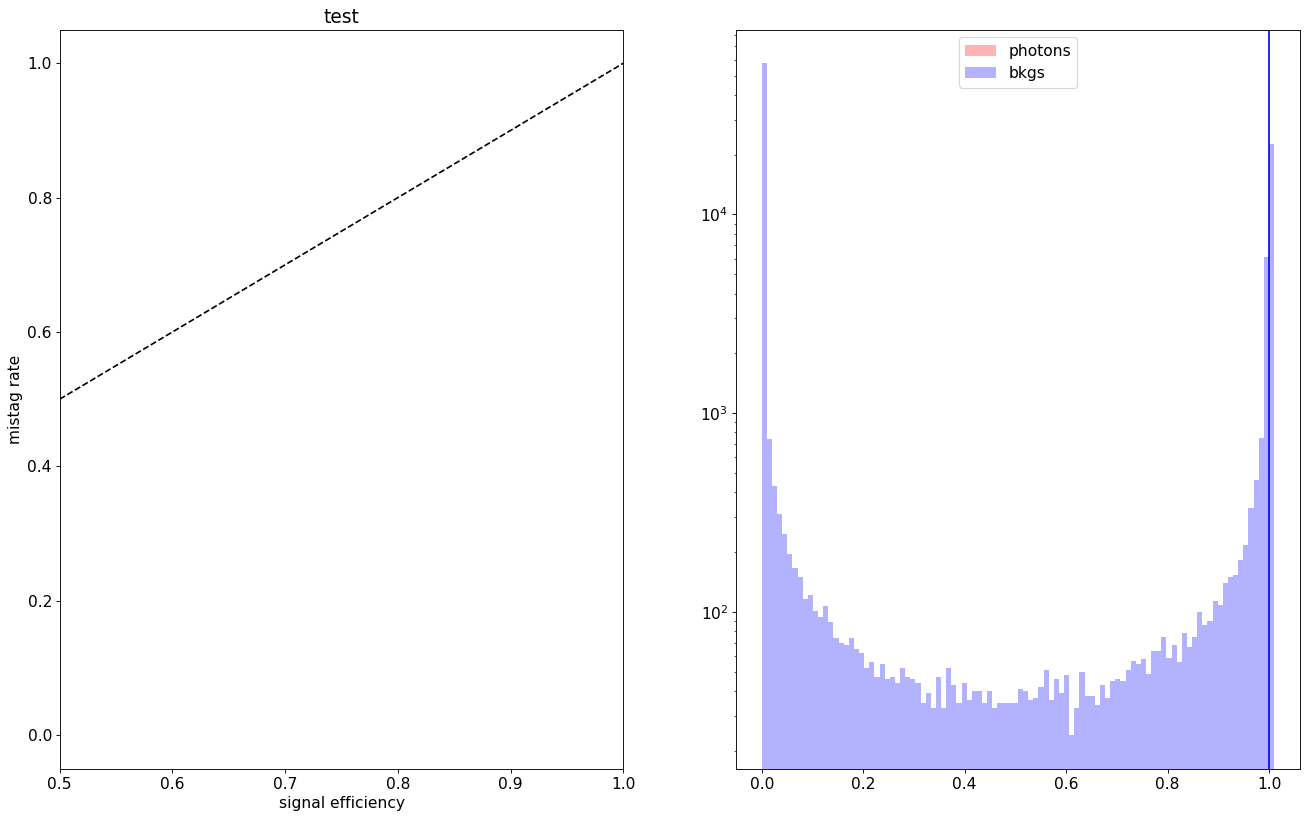

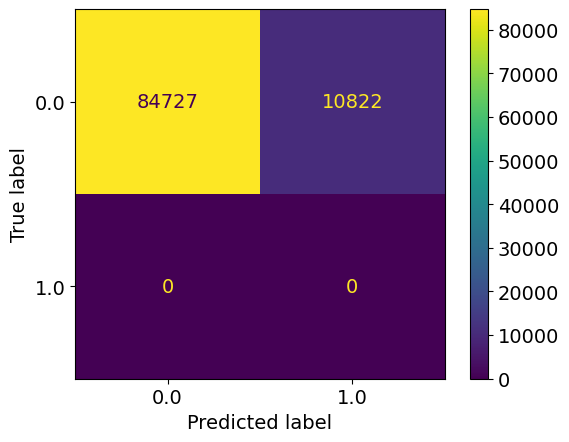

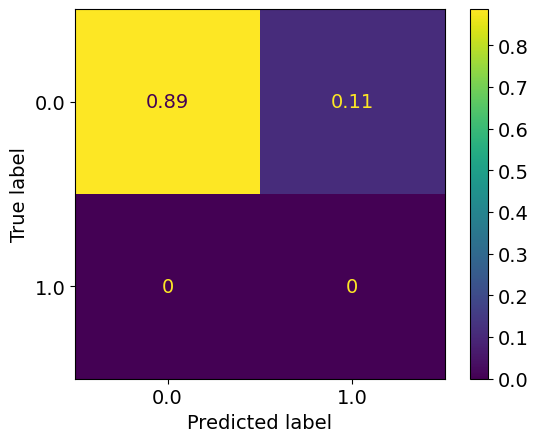

In [19]:
scores = []
trues = []
true_preds, num_preds = 0., 0.
#threshold90 = 0.152
mispredpho = []
mispredbkg = []
for data in tqdm(unbiasloader): ### change to loaderDNN for DNN
        datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
        #label = label.to(torch.long).squeeze()
        result = model(datax, masks, info3d)
        op = torch.exp(result)[:,1].detach().cpu().flatten().numpy()
        ip = label.detach().cpu().numpy().flatten()
        scores.append(op)
        trues.append( ip )
     
        ######## use the following lines if you want just the overall scores for accuracy etc (Use this when you want to extract threshold and plot confusion matrices)
        
        label = label.to(torch.long).squeeze()
        pred_labels = torch.argmax(result.cpu(), dim=-1) 
        true_preds += (pred_labels == label.cpu()).sum()
        num_preds += label.shape[0]
        
acc = true_preds / num_preds
print("accuracy:",np.mean(np.array(acc)))

########################### this part extracts the threshold value and plots overall confusion matrices

truesa = np.hstack(trues)
scoresa = np.hstack(scores)
fpr, tpr, thresholds = metrics.roc_curve(truesa, scoresa, pos_label=1)
aucv = metrics.auc(fpr, tpr)

tpr90,fpr90,threshold90_unbias = 0,0,0
for i,j,k in zip(tpr,fpr,thresholds):
    if i >0.995:
        tpr90 = i
        fpr90 = j
        threshold90_unbias = k
        break
print("threshold unbias:",threshold90_unbias)
print("threshold tot:",threshold90_tot)
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(20, 12),dpi=80)
plt.rcParams['font.size'] = '14'
### plot AUC
ax0.plot(tpr,fpr, linewidth=7.0, label= "AUC:"+str(round(aucv,3))+" eff:"+str(round(tpr90,3))+" @ bkg rejection rate:"+str(round(1-fpr90,3)))
ax0.set_xlabel("signal efficiency")
ax0.set_ylabel("mistag rate")
ax0.set_xlim([0.5,1])
ax0.plot([0.,1], [0.,1], 'k--')
ax0.title.set_text("test")
plt.legend()
#plt.show()

## plot signal-bkg distribution
ax1.hist(scoresa[truesa == 1],bins=100, range=[0,1.01], label='photons',linewidth=2.0, color="r" , alpha=0.3)
ax1.hist(scoresa[truesa == 0],bins=100, range=[0,1.01], label='bkgs',linewidth=2.0, color="b", alpha=0.3 )
ax1.axvline(threshold90_tot,c="b")
plt.yscale("log")
plt.legend()
plt.show()

#ax.text(0.6,0.6,aucv,)
#plt.yscale("log")
#plt.legend()
#plt.show()



### plot confusion matrices
ConfusionMatrixDisplay.from_predictions(truesa, np.where(scoresa>threshold90_tot, 1, 0))
plt.show()
ConfusionMatrixDisplay.from_predictions(truesa, np.where(scoresa>threshold90_tot, 1, 0), normalize="true")
plt.show()

### Plot mispredicted events

In [20]:
### set batch_size=1
testloader = torch.utils.data.DataLoader(tsdata, batch_size=1,shuffle=True)#, num_workers=2)
totalloader = torch.utils.data.DataLoader(combdataset, batch_size=1,shuffle=True)#, num_workers=2)
unbiasloader = torch.utils.data.DataLoader(unbiased_dataset, batch_size=1,shuffle=True)

#### mispredicted events on test dataset (testloader)

  0%|                                                                                                                         | 0/19953 [00:00<?, ?it/s]/opt/exp_soft/vo.gridcl.fr/software/torch/2.0.1/py311-cuda117/lib/python3.11/site-packages/torch/nn/modules/module.py:1501: UserWarning: FALLBACK path has been taken inside: runCudaFusionGroup. This is an indication that codegen Failed for some reason.
To debug try disable codegen fallback path via setting the env variable `export PYTORCH_NVFUSER_DISABLE=fallback`
 (Triggered internally at ../third_party/nvfuser/csrc/manager.cpp:335.)
  return forward_call(*args, **kwargs)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19953/19953 [01:43<00:00, 193.45it/s]


threshold 0.99999976
mispred_pho 56


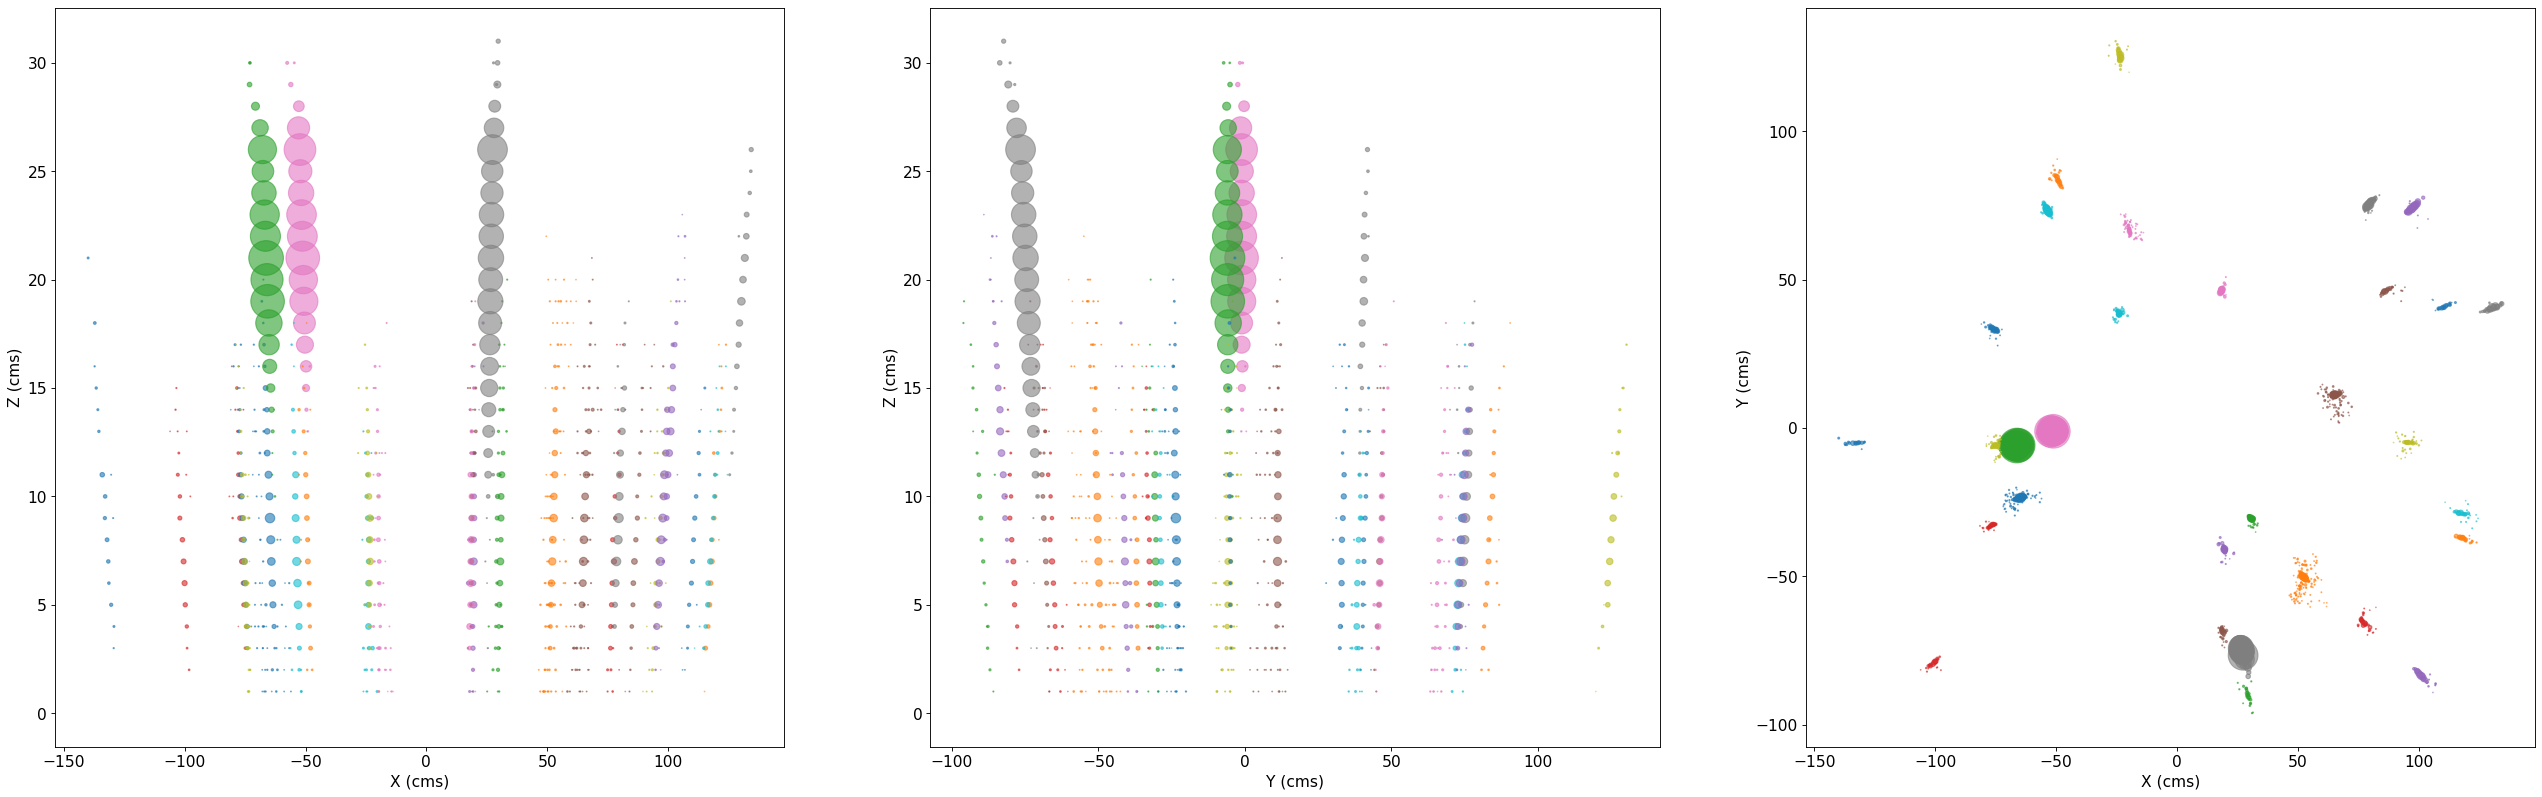

mispred_bkg 0


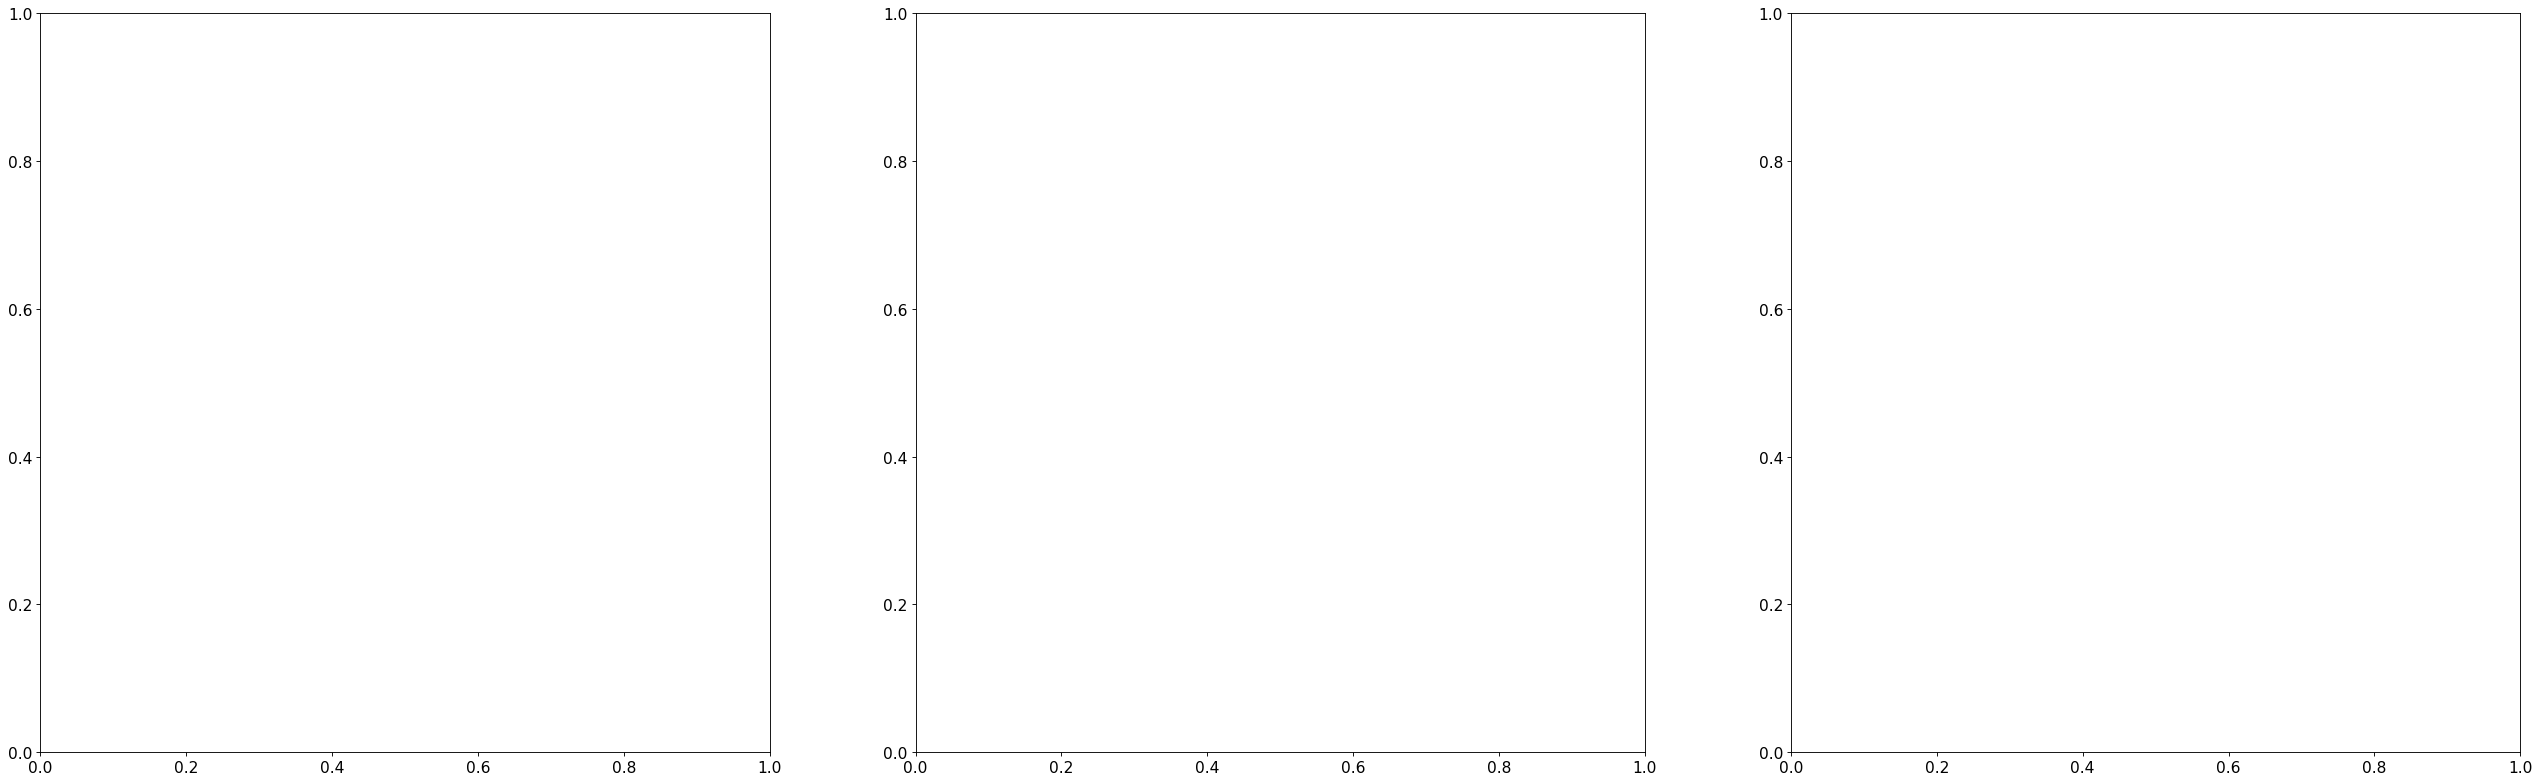

In [21]:
## REMEMBER to specify the threshold (to match the one obtained above)
scores = []
trues = []
true_preds, num_preds = 0., 0.
threshold90 = threshold90_test #0.152
mispredpho = []
mispredpho_3d = []
mispredbkg = []
mispredbkg_3d = []

for data in tqdm(testloader): ### change to loaderDNN for DNN
        datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
        #label = label.to(torch.long).squeeze()
        result = model(datax, masks, info3d)
        op = torch.exp(result)[:,1].detach().cpu().flatten().numpy()
        ip = label.detach().cpu().numpy().flatten()
        scores.append(op)
        trues.append( ip )

######## use the following lines if you want to store mispredicted event indices for plotting  (REMEMBER to set batch_size=1)

        opt = np.where(np.hstack(op)>threshold90, 1, 0)
        if (ip == 1)&(opt == 0):
            mispredpho.append(datax.detach().cpu().numpy())     ## get info of layer clusters (2D obj)
            mispredpho_3d.append(info3d.detach().cpu().numpy()) ## get info of tracksters (3D obj)
        elif (ip == 0)&(opt == 1):
            mispredbkg.append(datax.detach().cpu().numpy())     ## get info of layer clusters
            mispredbkg_3d.append(info3d.detach().cpu().numpy()) ## get info of tracksters


#Plot mispredicted events:
print("threshold", threshold90)

## mispredicted PHOTONS
fig, (ax0,ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
print("mispred_pho",len(mispredpho))
cc = 0
for uarray in mispredpho:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])
    #uarray = uarray[uarray[:,2]>0]
    ax0.scatter(uarray[:,0],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax0.set_xlabel('X (cms)')
    ax0.set_ylabel('Z (cms)')
    ax1.scatter(uarray[:,1],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax1.set_xlabel('Y (cms)')
    ax1.set_ylabel('Z (cms)')

    ax2.scatter(uarray[:,0],uarray[:,1],s=uarray[:,3]*10,alpha=0.6)
    ax2.set_xlabel('X (cms)')
    ax2.set_ylabel('Y (cms)')
    cc += 1
    if cc > 30:
        break    

plt.show()

## mispredicted PIONS
fig, (ax0,ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
print("mispred_bkg",len(mispredbkg))
cc = 0
for uarray in mispredbkg:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])
    #uarray = uarray[uarray[:,2]>0]
    ax0.scatter(uarray[:,0],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax0.set_xlabel('X (cms)')
    ax0.set_ylabel('Z (cms)')
    ax1.scatter(uarray[:,1],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax1.set_xlabel('Y (cms)')
    ax1.set_ylabel('Z (cms)')
    ax2.scatter(uarray[:,0],uarray[:,1],s=uarray[:,3]*10,alpha=0.6)
    ax2.set_xlabel('X (cms)')
    ax2.set_ylabel('Y (cms)')
    cc += 1
    if cc > 30:
        break    

plt.show()

Plot Barycenter of mispredicted photons
len: 56


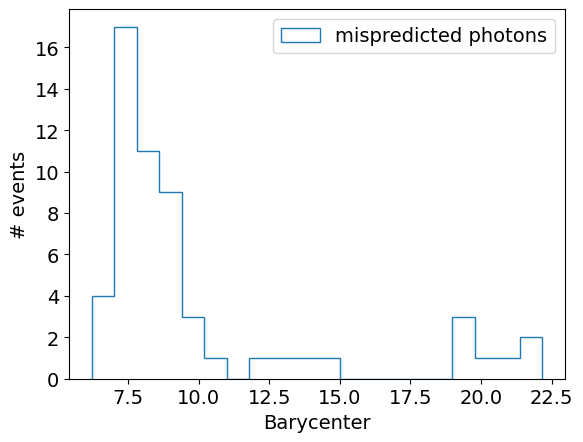

Plot Barycenter of mispredicted pions
len: 0


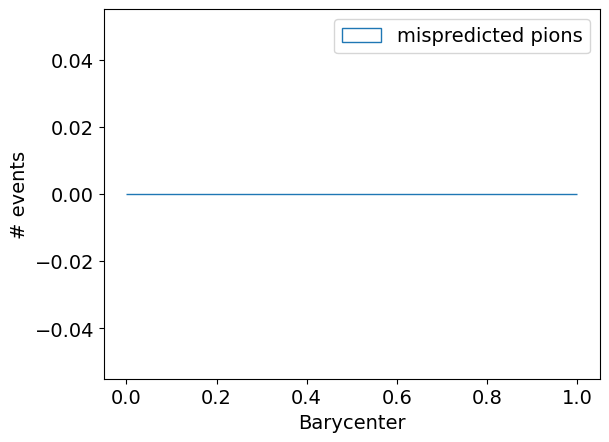

In [22]:
# mispredicted PHOTONS
print("Plot Barycenter of mispredicted photons")

fig, ax = plt.subplots(1,1)#,figsize=(40, 12),dpi=80)

barycenter_mis_pho = []
for uarray in mispredpho:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])

    barycenter_z = np.average(uarray[:,2], weights=uarray[:,3])
    barycenter_mis_pho.append(barycenter_z)
    #print(barycenter_z)

print("len:",len(barycenter_mis_pho))
#print(barycenter_mis_pho)

ax.hist(barycenter_mis_pho, bins=20, histtype='step',linewidth=1,label='mispredicted photons')
ax.legend()
ax.set_xlabel('Barycenter')
ax.set_ylabel('# events')
 
plt.show()


### -------------
# mispredicted PIONS
print("Plot Barycenter of mispredicted pions")

fig, ax = plt.subplots(1,1)#,figsize=(40, 12),dpi=80)

barycenter_mis_bkg = []
for uarray in mispredbkg:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])

    barycenter_z = np.average(uarray[:,2], weights=uarray[:,3])
    barycenter_mis_bkg.append(barycenter_z)
    #print(barycenter_z)

print("len:",len(barycenter_mis_bkg))
#print(barycenter_mis_pho)

ax.hist(barycenter_mis_bkg, bins=20, histtype='step',linewidth=1,label='mispredicted pions')
ax.legend()
ax.set_xlabel('Barycenter')
ax.set_ylabel('# events')
 

plt.show()


Plot 3D features of mispredicted photons
mispredicted pho: 56


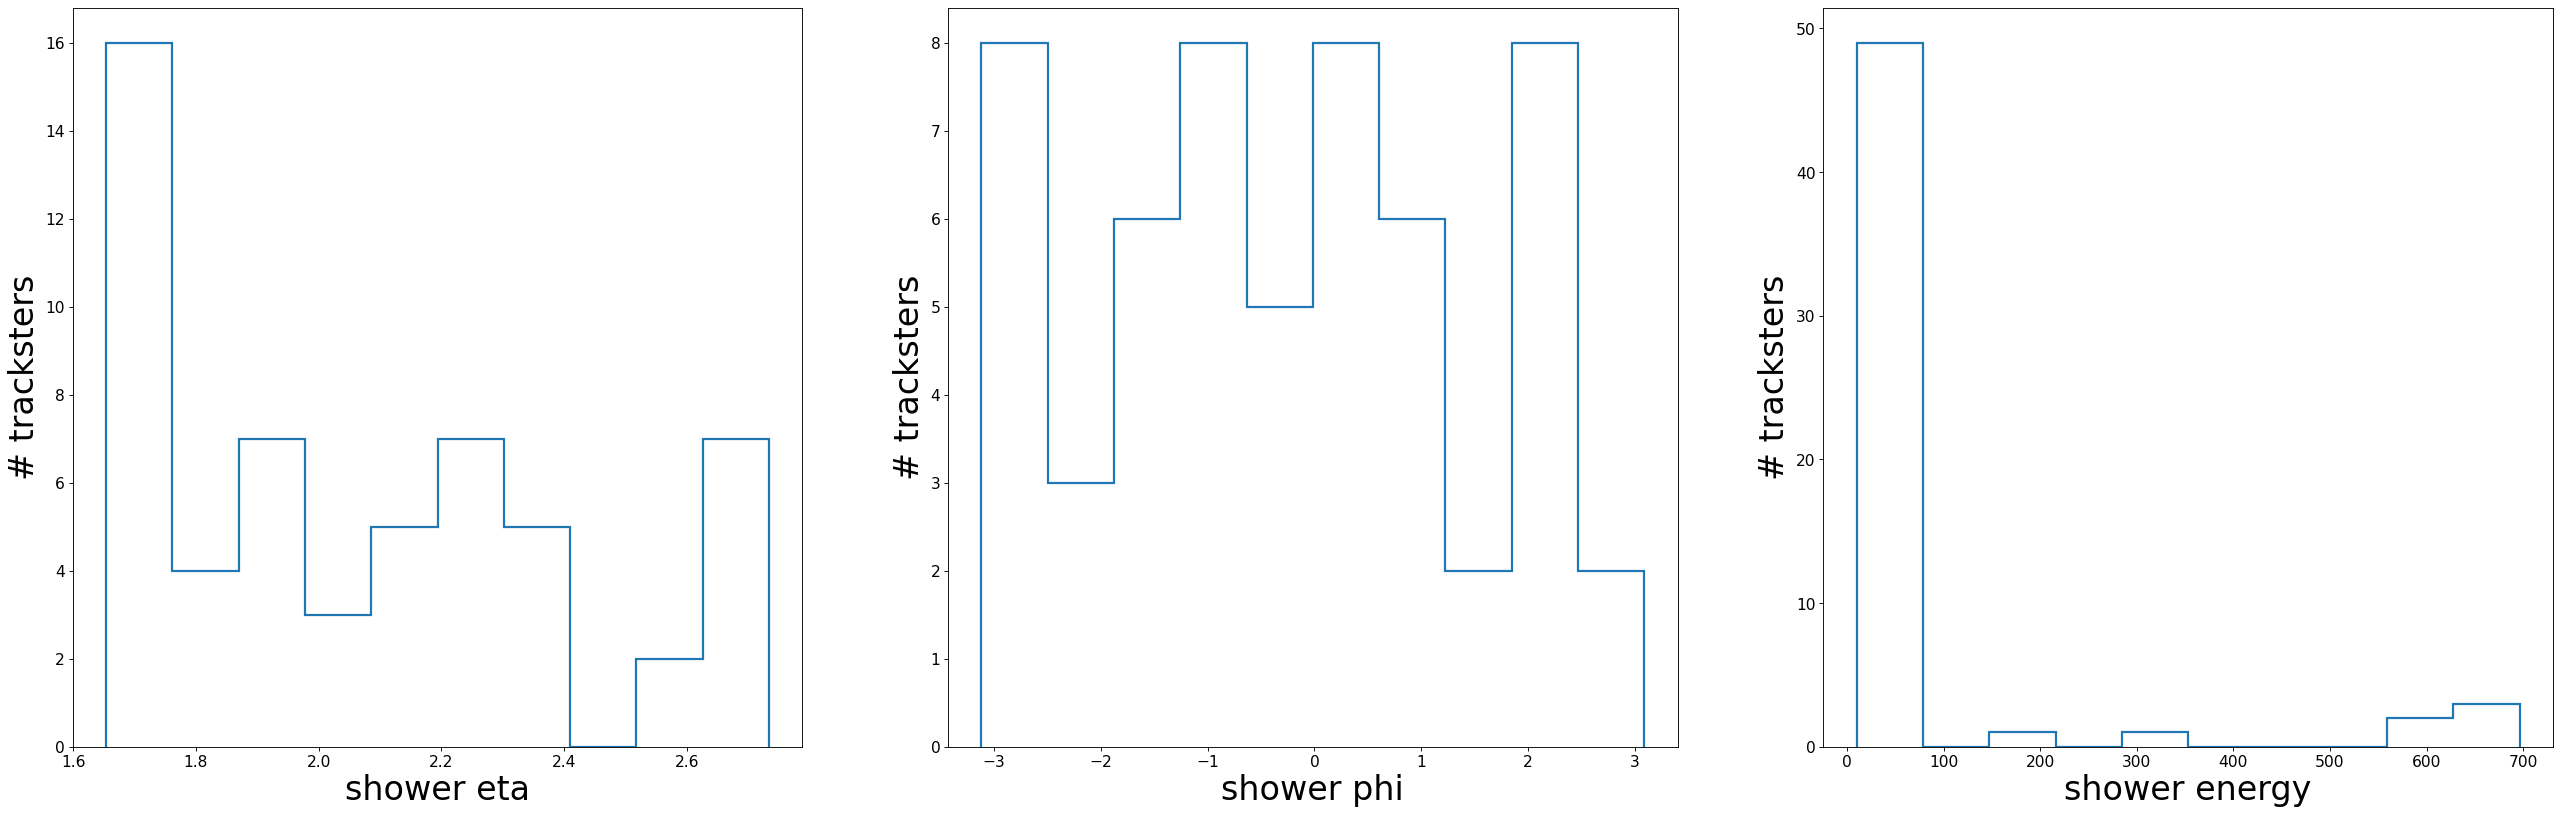

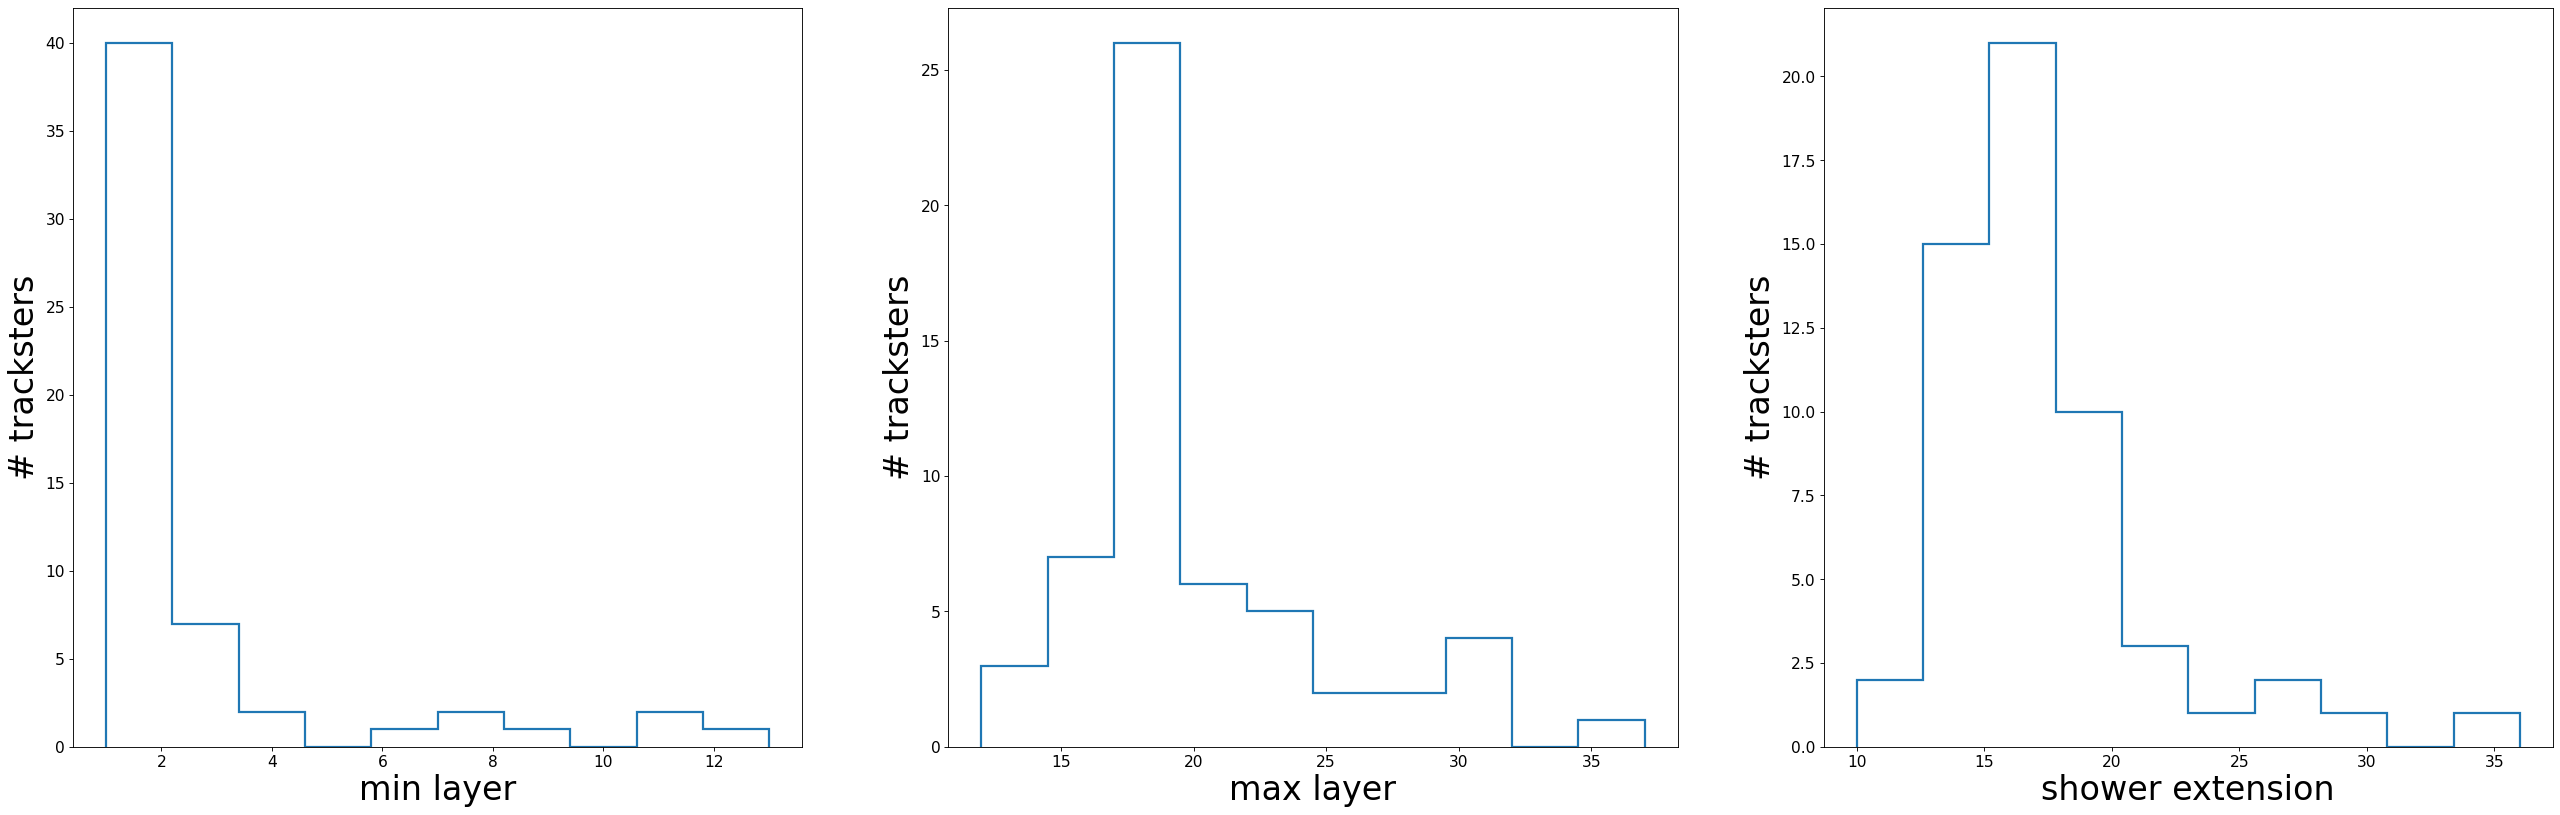

Plot 3D features of mispredicted pions
mispredicted bkg: 0


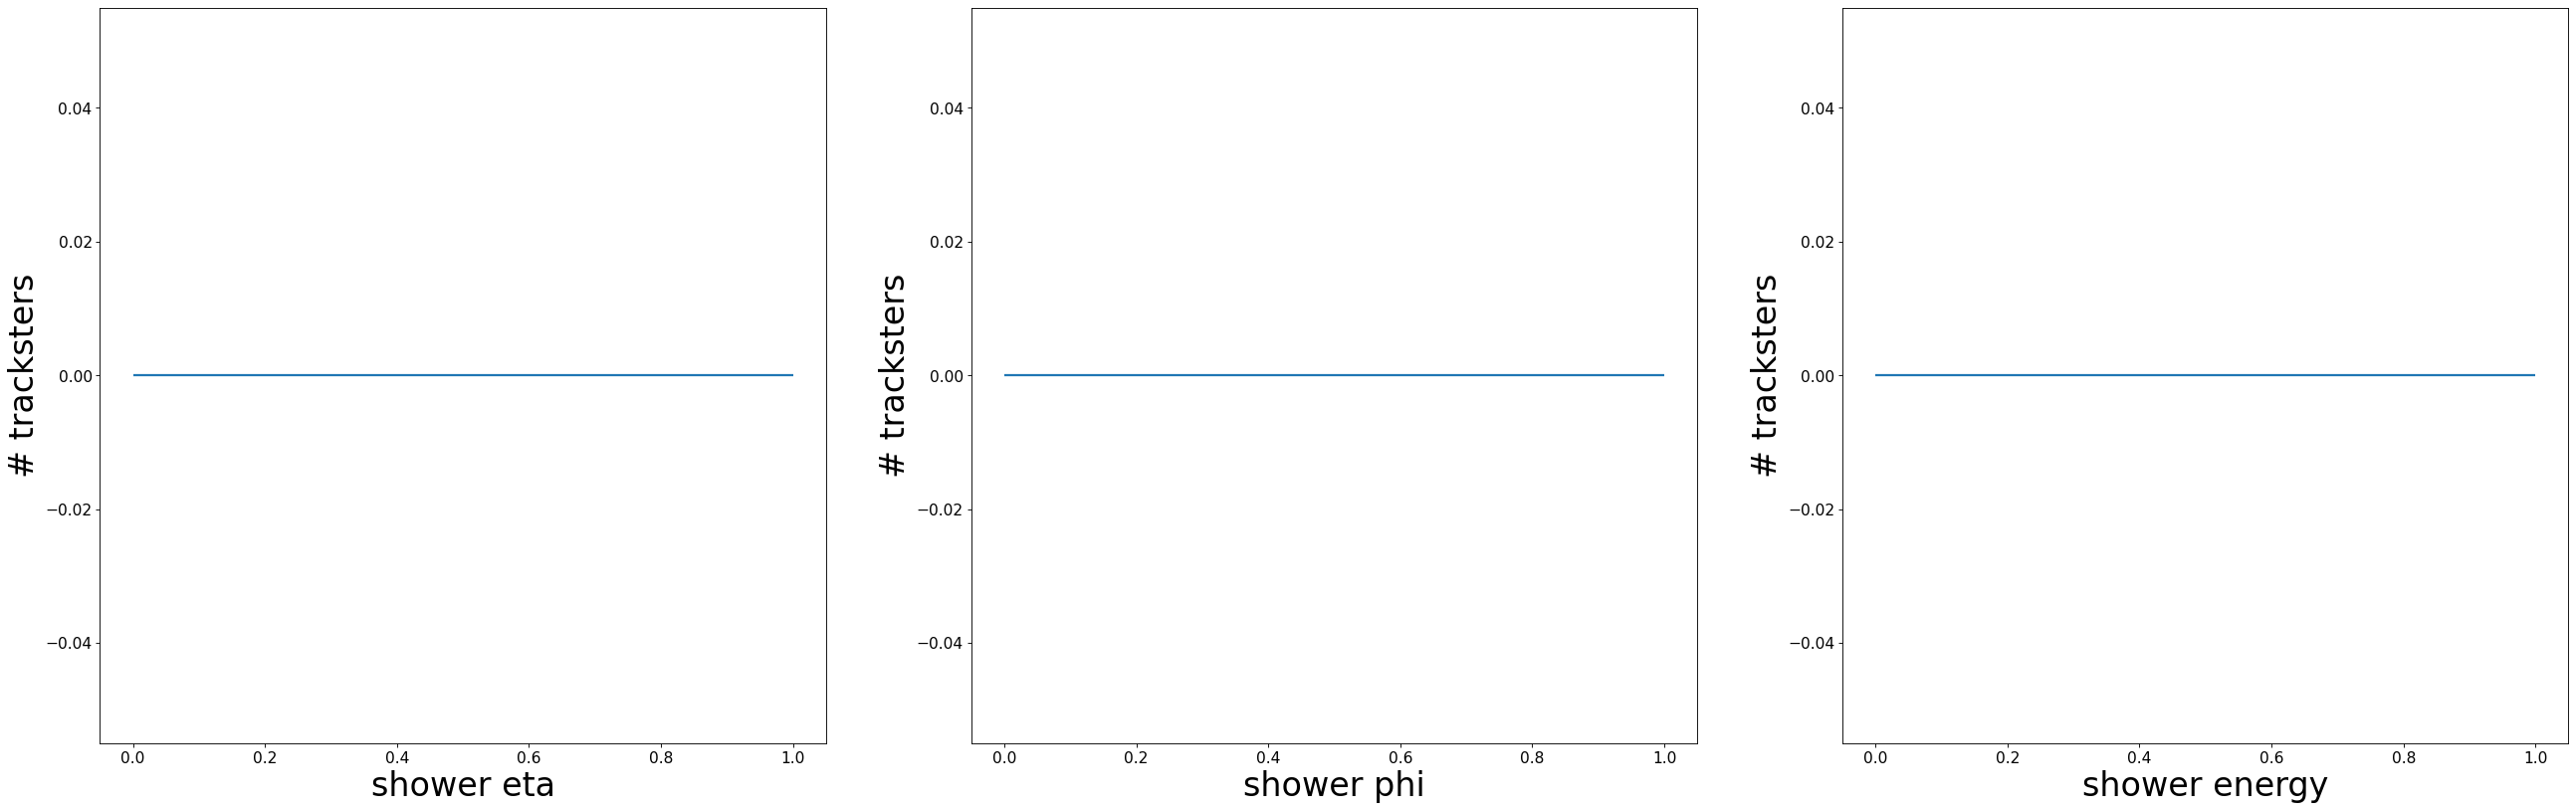

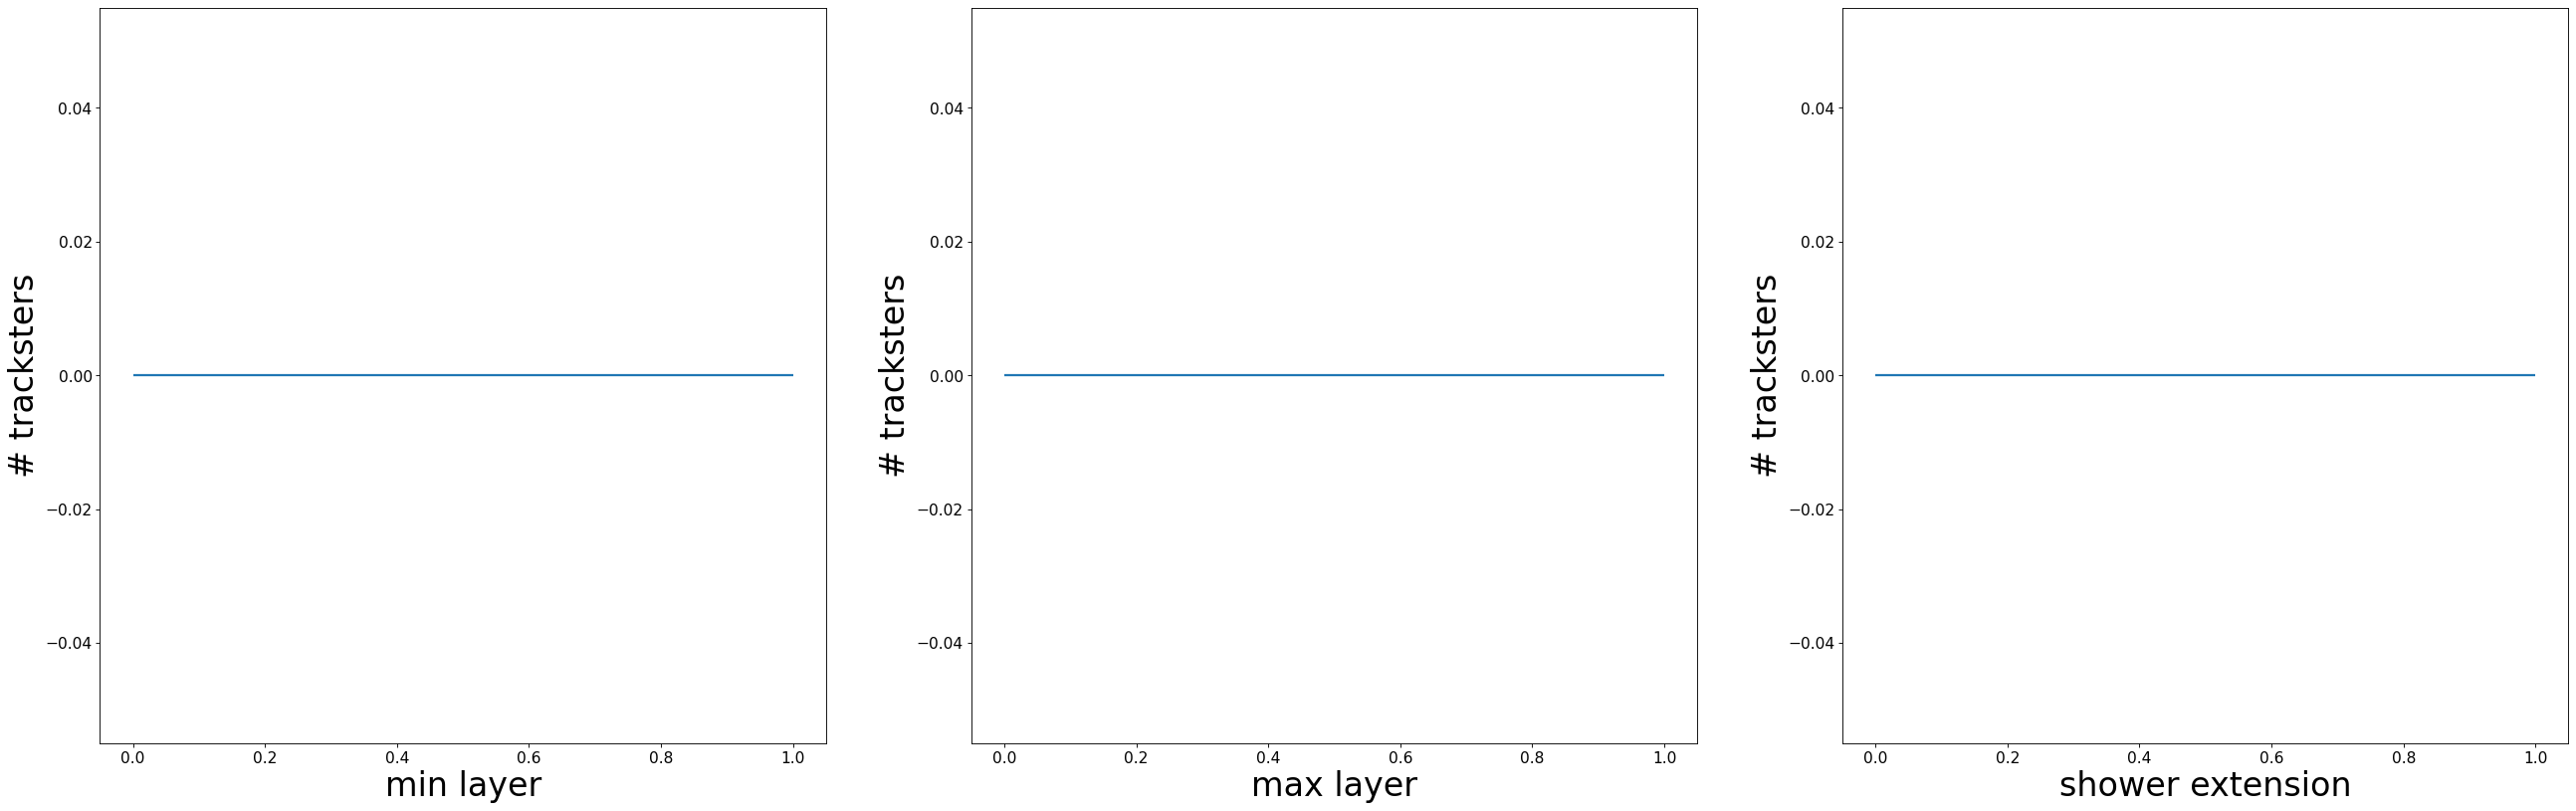

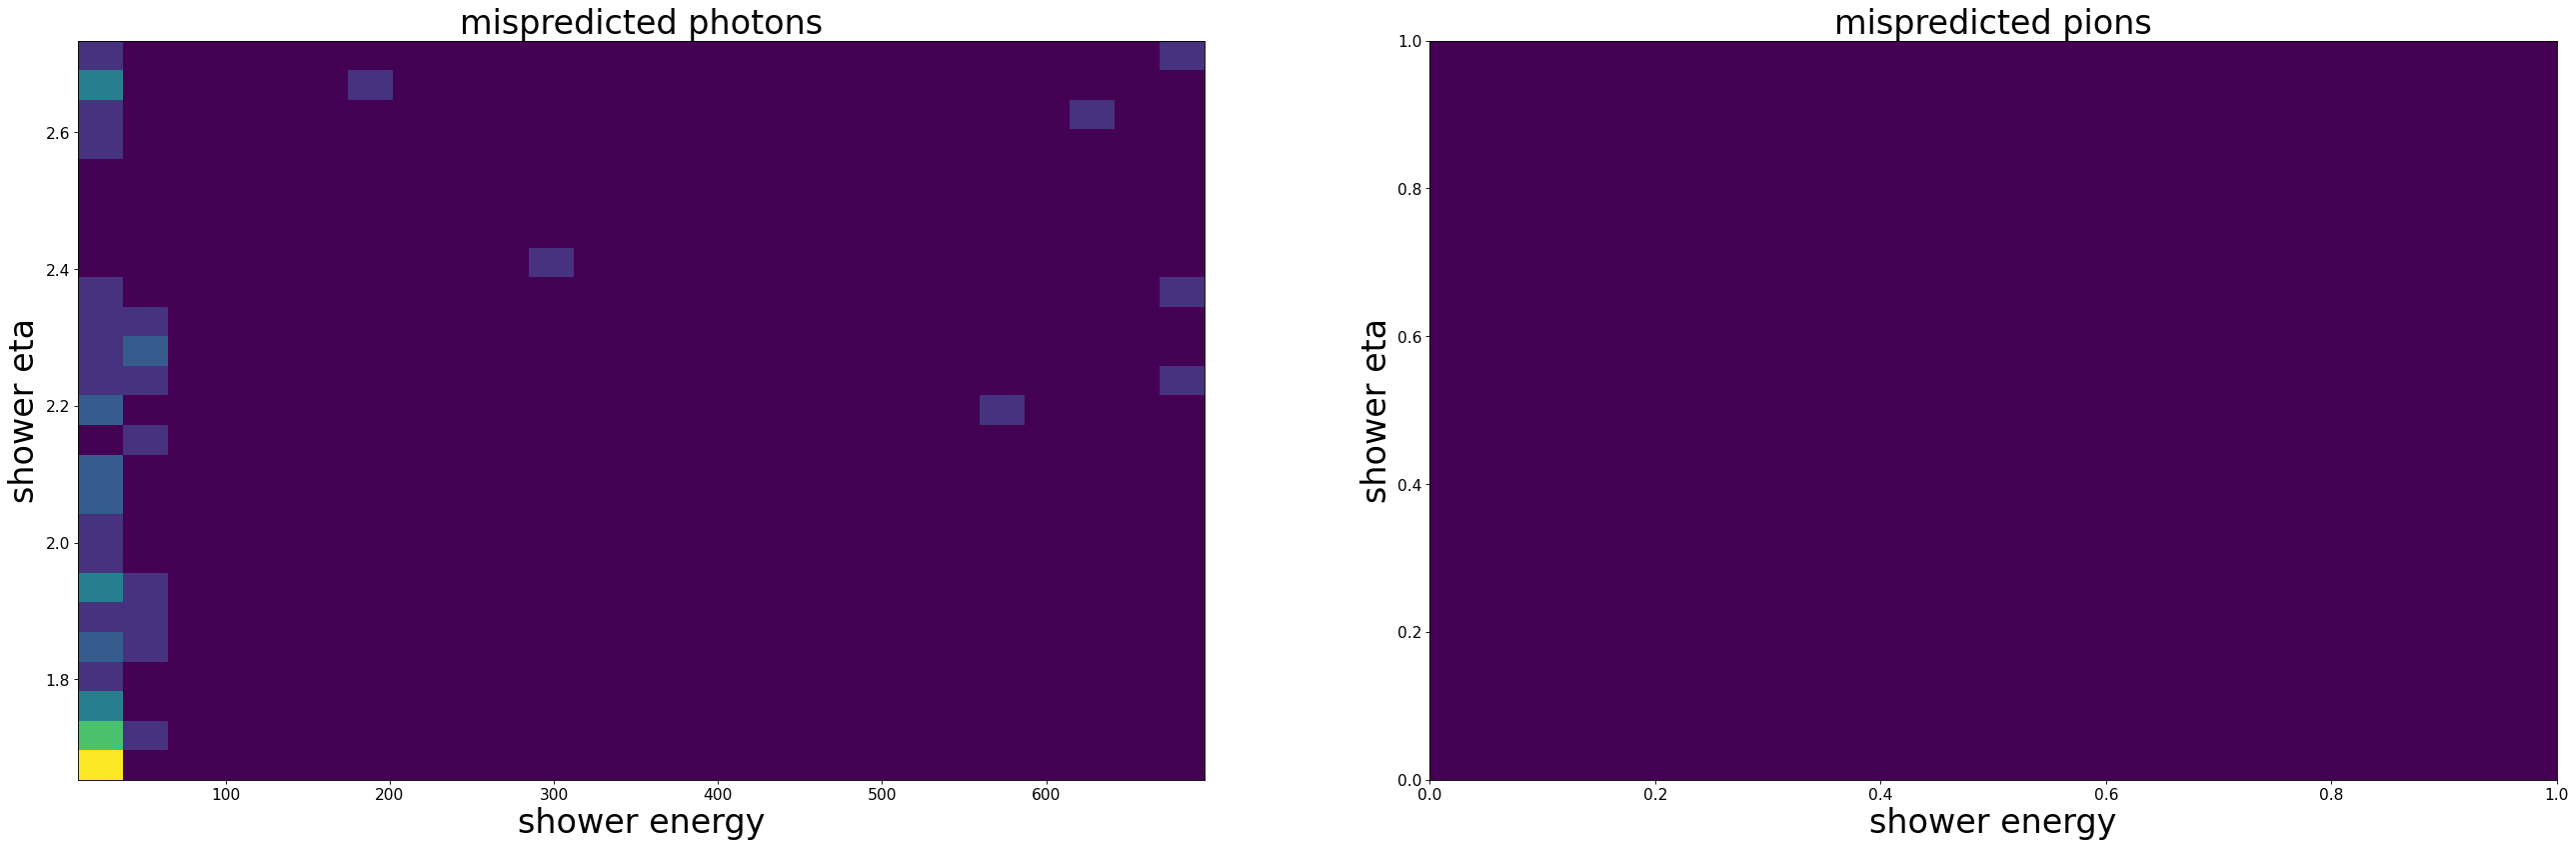

In [23]:
# mispredicted PHOTONS
print("Plot 3D features of mispredicted photons")

# mispredpho_3d is tensor of trackster information with 
# - mispredpho_3d[0] = eta
# - mispredpho_3d[1] = phi
# - mispredpho_3d[2] = energy
# - mispredpho_3d[3] = min layer
# - mispredpho_3d[4] = max layer


eta_mis_pho_3D = []  
phi_mis_pho_3D = []  
en_mis_pho_3D = []
minL_mis_pho_3D = []
maxL_mis_pho_3D = []
ext_mis_pho_3D = [] # shower extension

for tracksterarray in mispredpho_3d:

    eta_mis_pho_3D.append(tracksterarray[0][0]) #photons have eta >0 because of the selection
    phi_mis_pho_3D.append(tracksterarray[0][1])
    en_mis_pho_3D.append(tracksterarray[0][2])
    minL_mis_pho_3D.append(tracksterarray[0][3])
    maxL_mis_pho_3D.append(tracksterarray[0][4])
    ext_mis_pho_3D.append(abs(tracksterarray[0][4] - tracksterarray[0][3]))

print('mispredicted pho:',len(mispredpho_3d))

fig, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
ax0.hist(eta_mis_pho_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax0.set_xlabel('shower eta',fontsize=30)
ax0.set_ylabel('# tracksters',fontsize=30)
ax1.hist(phi_mis_pho_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax1.set_xlabel('shower phi',fontsize=30)
ax1.set_ylabel('# tracksters',fontsize=30)
ax2.hist(en_mis_pho_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax2.set_xlabel('shower energy',fontsize=30)
ax2.set_ylabel('# tracksters',fontsize=30)

plt.show()

fig, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
ax0.hist(minL_mis_pho_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax0.set_xlabel('min layer',fontsize=30)
ax0.set_ylabel('# tracksters',fontsize=30)
ax1.hist(maxL_mis_pho_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax1.set_xlabel('max layer',fontsize=30)
ax1.set_ylabel('# tracksters',fontsize=30)
ax2.hist(ext_mis_pho_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax2.set_xlabel('shower extension',fontsize=30)
ax2.set_ylabel('# tracksters',fontsize=30)
 
plt.show()


# mispredicted PIONS
print("Plot 3D features of mispredicted pions")

# mispredbkg_3d is tensor of trackster information with 
# - mispredbkg_3d[0] = eta
# - mispredbkg_3d[1] = phi
# - mispredbkg_3d[2] = energy
# - mispredbkg_3d[3] = min layer
# - mispredbkg_3d[4] = max layer


eta_mis_bkg_3D = []  
phi_mis_bkg_3D = []  
en_mis_bkg_3D = []
minL_mis_bkg_3D = []
maxL_mis_bkg_3D = []
ext_mis_bkg_3D = [] # shower extension

for tracksterarray in mispredbkg_3d:

    eta_mis_bkg_3D.append(abs(tracksterarray[0][0])) # bkg do not have eta>0, so the abs is imposed
    phi_mis_bkg_3D.append(tracksterarray[0][1])
    en_mis_bkg_3D.append(tracksterarray[0][2])
    minL_mis_bkg_3D.append(tracksterarray[0][3])
    maxL_mis_bkg_3D.append(tracksterarray[0][4])
    ext_mis_bkg_3D.append(abs(tracksterarray[0][4] - tracksterarray[0][3]))

print('mispredicted bkg:',len(mispredbkg_3d))

fig, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
ax0.hist(eta_mis_bkg_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax0.set_xlabel('shower eta',fontsize=30)
ax0.set_ylabel('# tracksters',fontsize=30)
ax1.hist(phi_mis_bkg_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax1.set_xlabel('shower phi',fontsize=30)
ax1.set_ylabel('# tracksters',fontsize=30)
ax2.hist(en_mis_bkg_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax2.set_xlabel('shower energy',fontsize=30)
ax2.set_ylabel('# tracksters',fontsize=30)

plt.show()

fig, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
ax0.hist(minL_mis_bkg_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax0.set_xlabel('min layer',fontsize=30)
ax0.set_ylabel('# tracksters',fontsize=30)
ax1.hist(maxL_mis_bkg_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax1.set_xlabel('max layer',fontsize=30)
ax1.set_ylabel('# tracksters',fontsize=30)
ax2.hist(ext_mis_bkg_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax2.set_xlabel('shower extension',fontsize=30)
ax2.set_ylabel('# tracksters',fontsize=30)
 
plt.show()

# eta vs energy
fig, (ax0,ax1) = plt.subplots(1, 2,figsize=(40, 12),dpi=80)
ax0.hist2d(en_mis_pho_3D, eta_mis_pho_3D, bins=25)
ax0.set_title('mispredicted photons',fontsize=30)
ax0.set_xlabel('shower energy',fontsize=30)
ax0.set_ylabel('shower eta',fontsize=30)
ax1.hist2d(en_mis_bkg_3D, eta_mis_bkg_3D, bins=25)
ax1.set_title('mispredicted pions',fontsize=30)
ax1.set_xlabel('shower energy',fontsize=30)
ax1.set_ylabel('shower eta',fontsize=30)
plt.show()

#### mispredicted events on full dataset (totalloader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99761/99761 [08:39<00:00, 192.04it/s]


threshold 0.99999976
mispred_pho 294


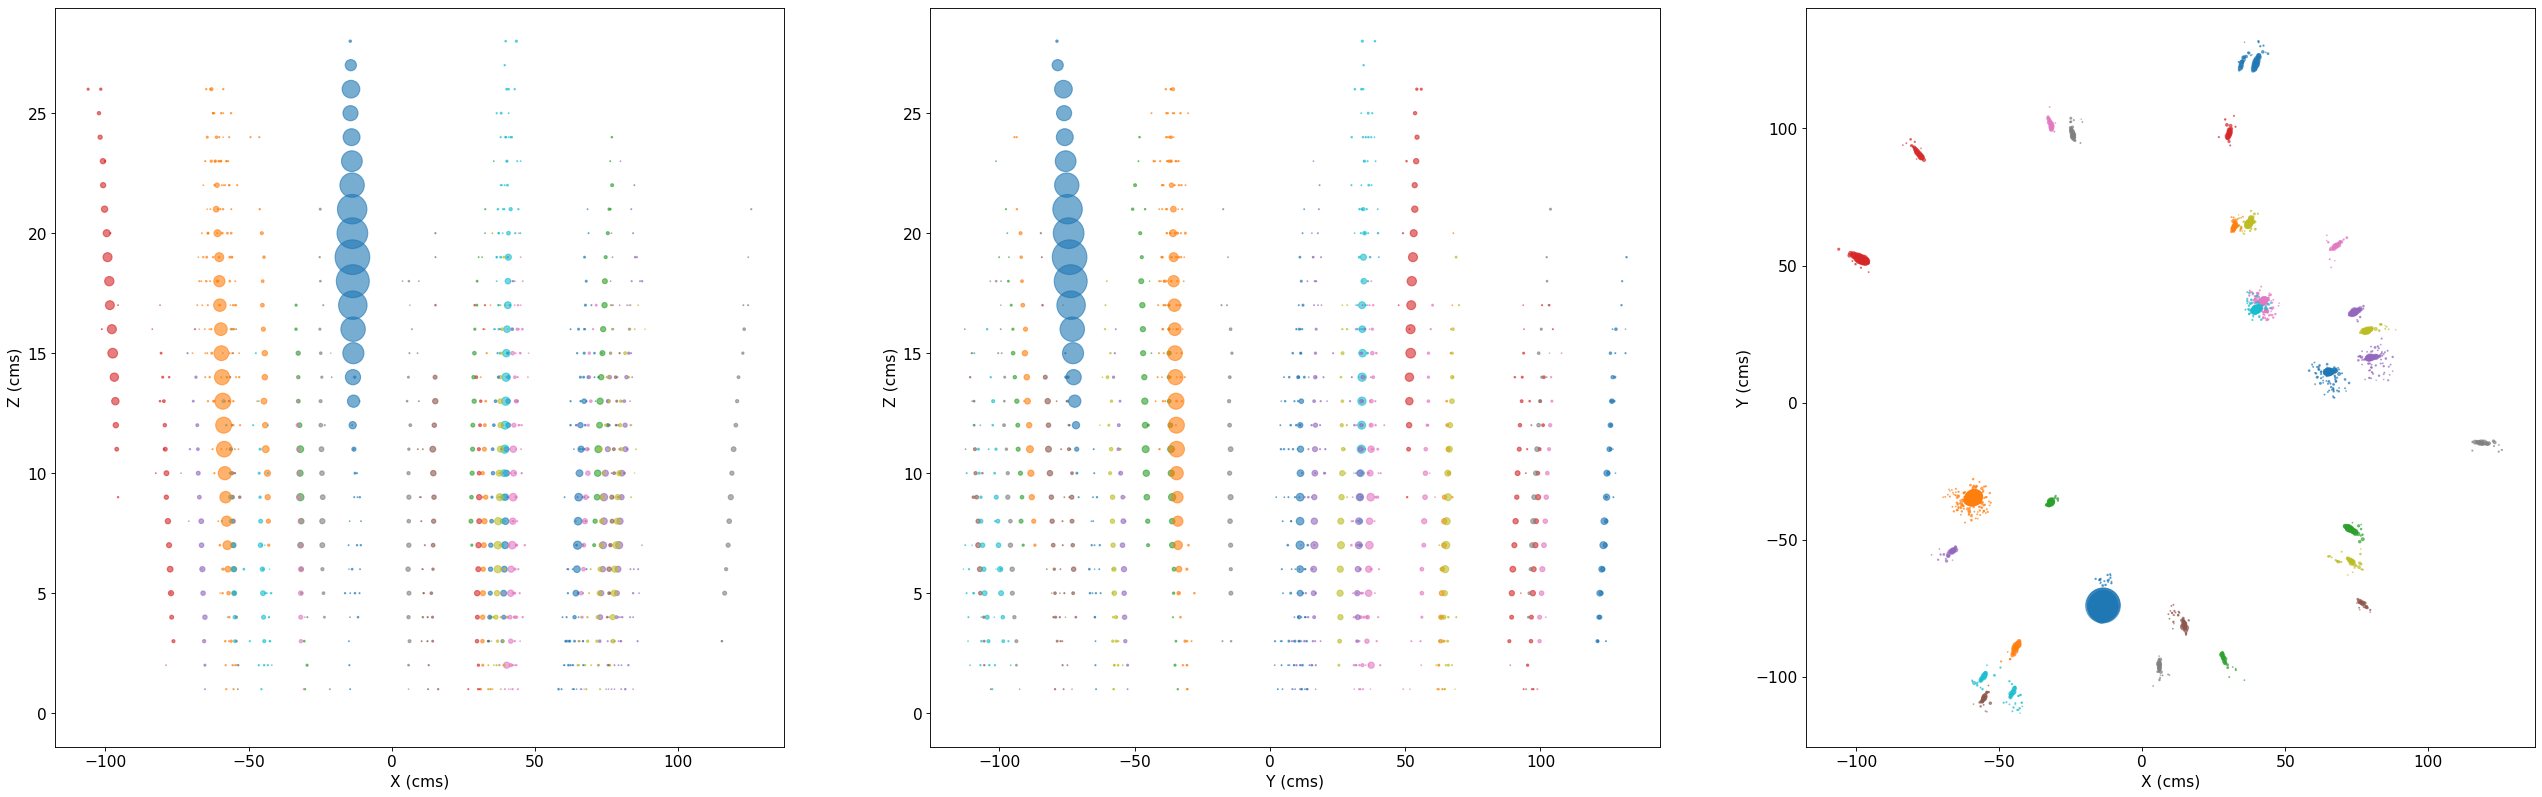

mispred_bkg 0


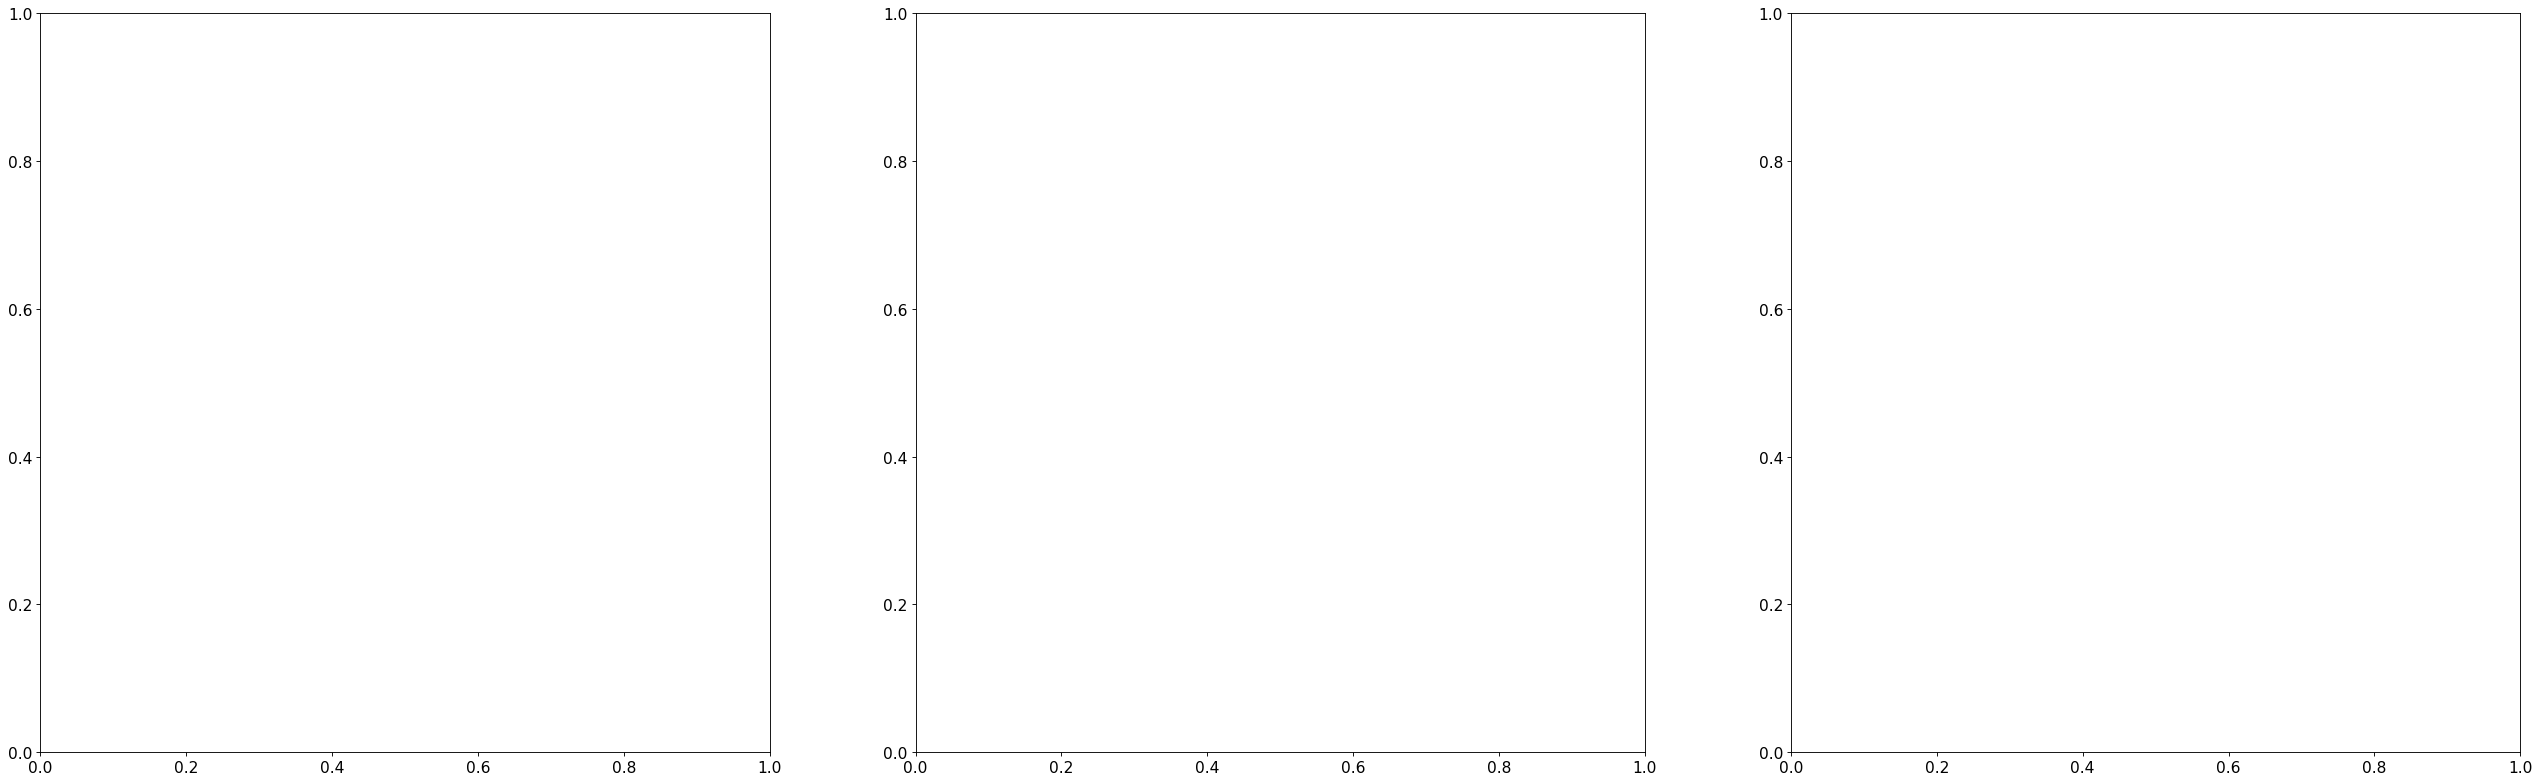

In [24]:
## REMEMBER to specify the threshold (to match the one obtained above)
scores = []
trues = []
true_preds, num_preds = 0., 0.
threshold90 = threshold90_tot #0.152
mispredpho = []
mispredpho_3d = []
mispredbkg = []
mispredbkg_3d = []

for data in tqdm(totalloader): ### change to loaderDNN for DNN
        datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
        #label = label.to(torch.long).squeeze()
        result = model(datax, masks, info3d)
        op = torch.exp(result)[:,1].detach().cpu().flatten().numpy()
        ip = label.detach().cpu().numpy().flatten()
        scores.append(op)
        trues.append( ip )

######## use the following lines if you want to store mispredicted event indices for plotting  (REMEMBER to set batch_size=1)

        opt = np.where(np.hstack(op)>threshold90, 1, 0)
        if (ip == 1)&(opt == 0):
            mispredpho.append(datax.detach().cpu().numpy())
            mispredpho_3d.append(info3d.detach().cpu().numpy()) ## get info of tracksters (3D obj)
        elif (ip == 0)&(opt == 1):
            mispredbkg.append(datax.detach().cpu().numpy())
            mispredbkg_3d.append(info3d.detach().cpu().numpy()) ## get info of tracksters (3D obj)



#Plot mispredicted events:
print("threshold", threshold90)

## mispredicted PHOTONS
fig, (ax0,ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
print("mispred_pho",len(mispredpho))
cc = 0
for uarray in mispredpho:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])
    #uarray = uarray[uarray[:,2]>0]
    ax0.scatter(uarray[:,0],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax0.set_xlabel('X (cms)')
    ax0.set_ylabel('Z (cms)')
    ax1.scatter(uarray[:,1],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax1.set_xlabel('Y (cms)')
    ax1.set_ylabel('Z (cms)')

    ax2.scatter(uarray[:,0],uarray[:,1],s=uarray[:,3]*10,alpha=0.6)
    ax2.set_xlabel('X (cms)')
    ax2.set_ylabel('Y (cms)')
    cc += 1
    if cc > 30:
        break    

plt.show()

## mispredicted PIONS
fig, (ax0,ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
print("mispred_bkg",len(mispredbkg))
cc = 0
for uarray in mispredbkg:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])
    #uarray = uarray[uarray[:,2]>0]
    ax0.scatter(uarray[:,0],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax0.set_xlabel('X (cms)')
    ax0.set_ylabel('Z (cms)')
    ax1.scatter(uarray[:,1],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax1.set_xlabel('Y (cms)')
    ax1.set_ylabel('Z (cms)')

    ax2.scatter(uarray[:,0],uarray[:,1],s=uarray[:,3]*10,alpha=0.6)
    ax2.set_xlabel('X (cms)')
    ax2.set_ylabel('Y (cms)')
    cc += 1
    if cc > 30:
        break    

plt.show()

Plot Barycenter of mispredicted photons
len: 294


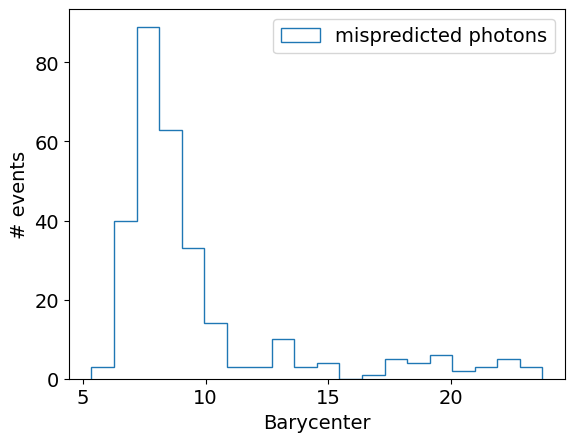

Plot Barycenter of mispredicted pions
len: 0


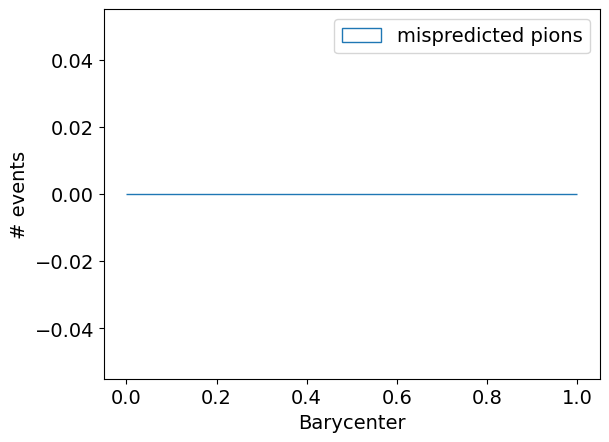

In [25]:
# mispredicted PHOTONS
print("Plot Barycenter of mispredicted photons")

fig, ax = plt.subplots(1,1)#,figsize=(40, 12),dpi=80)

barycenter_mis_pho = []
for uarray in mispredpho:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])

    barycenter_z = np.average(uarray[:,2], weights=uarray[:,3])
    barycenter_mis_pho.append(barycenter_z)
    #print(barycenter_z)

print("len:",len(barycenter_mis_pho))
#print(barycenter_mis_pho)

ax.hist(barycenter_mis_pho, bins=20, histtype='step',linewidth=1,label='mispredicted photons')
ax.legend()
ax.set_xlabel('Barycenter')
ax.set_ylabel('# events')
 
plt.show()


### -------------
# mispredicted PIONS
print("Plot Barycenter of mispredicted pions")

fig, ax = plt.subplots(1,1)#,figsize=(40, 12),dpi=80)

barycenter_mis_bkg = []
for uarray in mispredbkg:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])

    barycenter_z = np.average(uarray[:,2], weights=uarray[:,3])
    barycenter_mis_bkg.append(barycenter_z)
    #print(barycenter_z)

print("len:",len(barycenter_mis_bkg))
#print(barycenter_mis_pho)

ax.hist(barycenter_mis_bkg, bins=20, histtype='step',linewidth=1,label='mispredicted pions')
ax.legend()
ax.set_xlabel('Barycenter')
ax.set_ylabel('# events')
 

plt.show()

Plot 3D features of mispredicted photons
mispredicted pho: 294


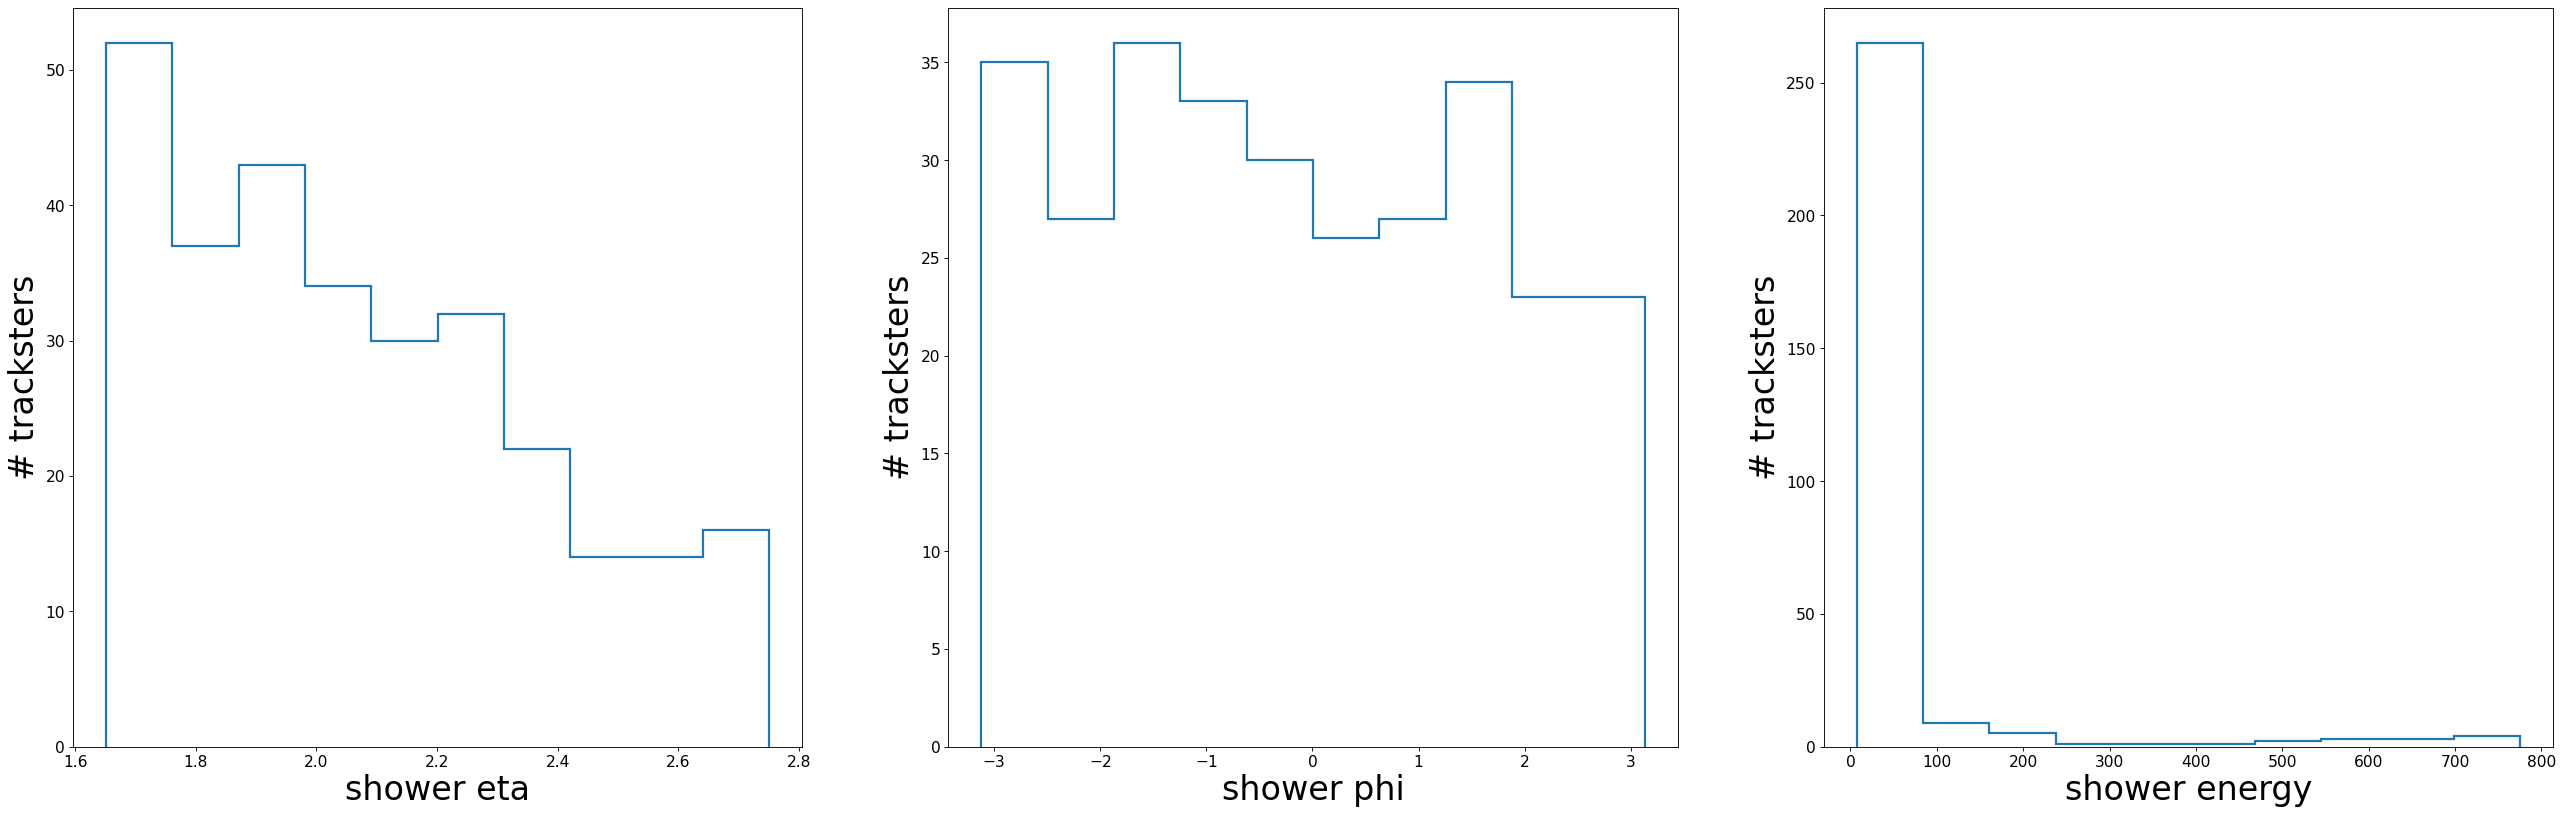

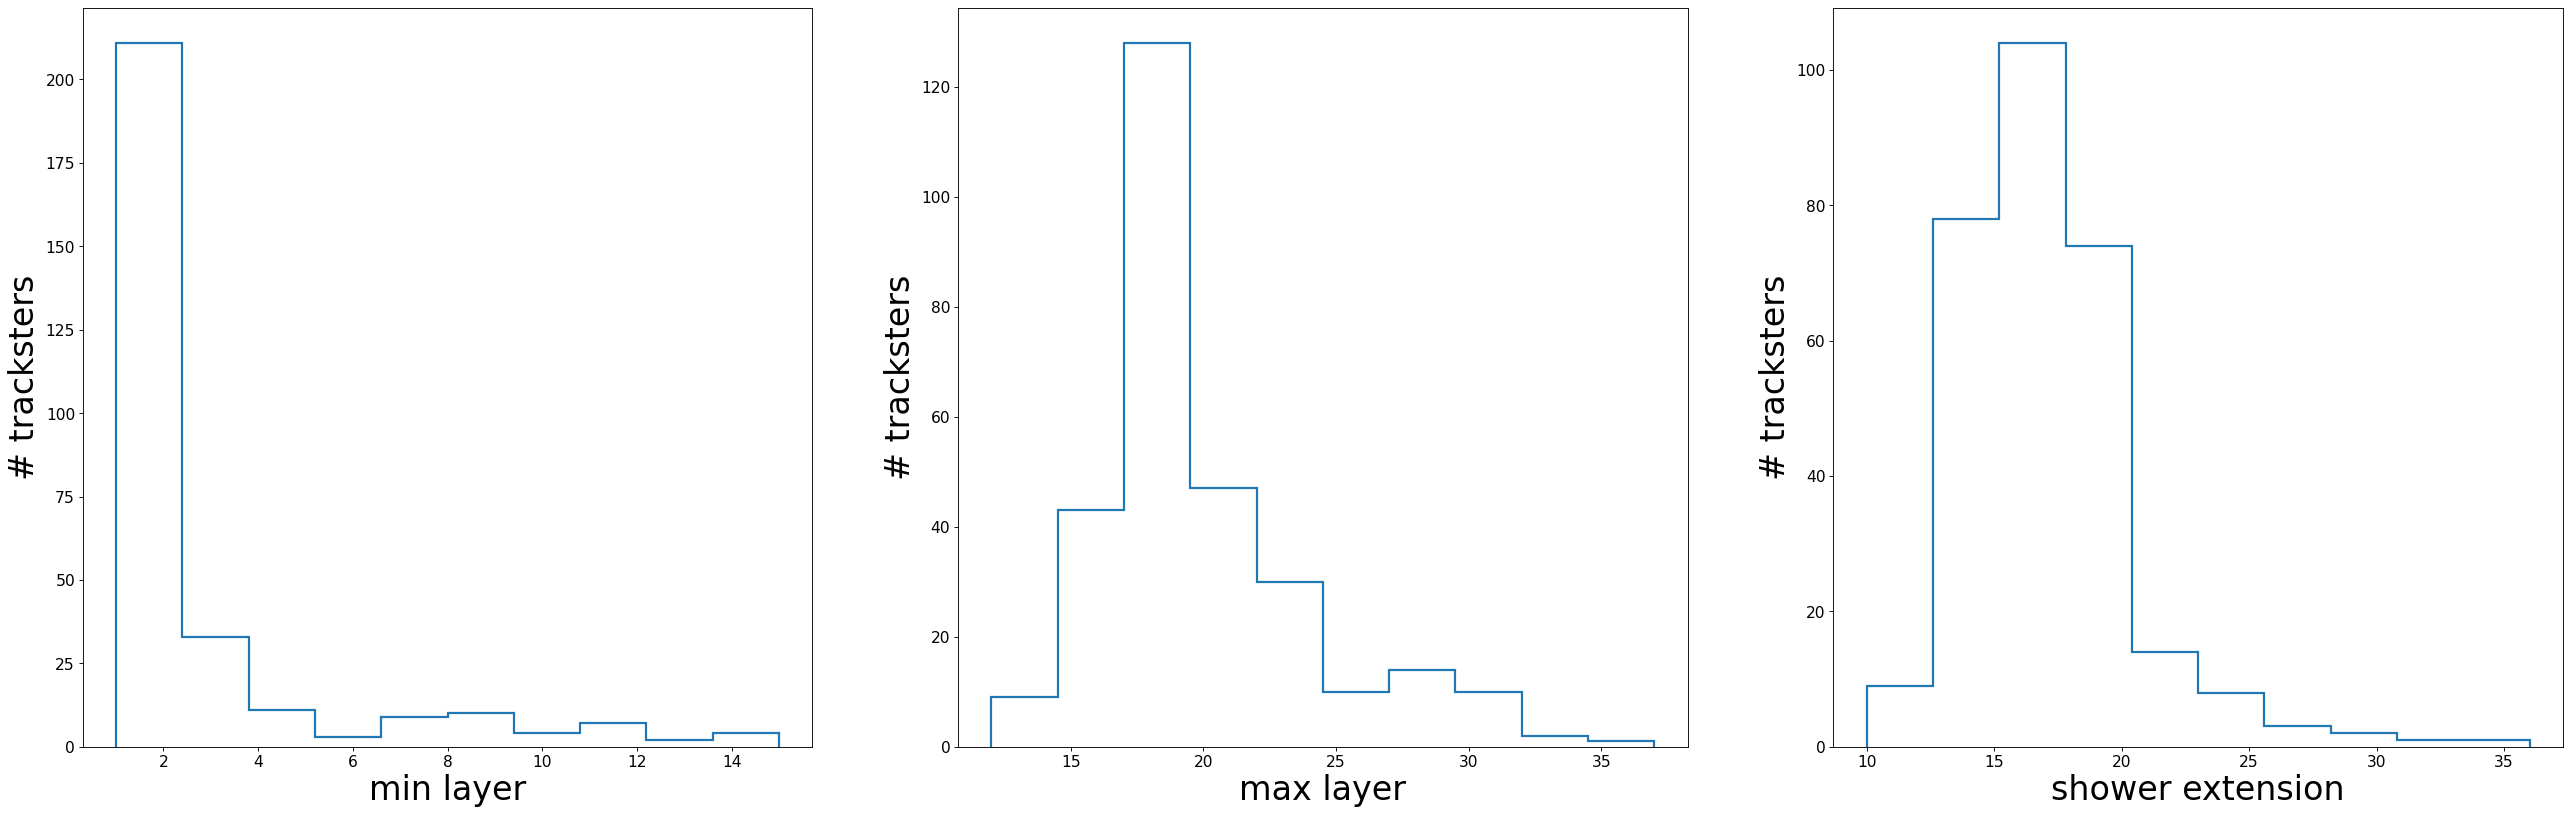

Plot 3D features of mispredicted pions
mispredicted bkg: 0


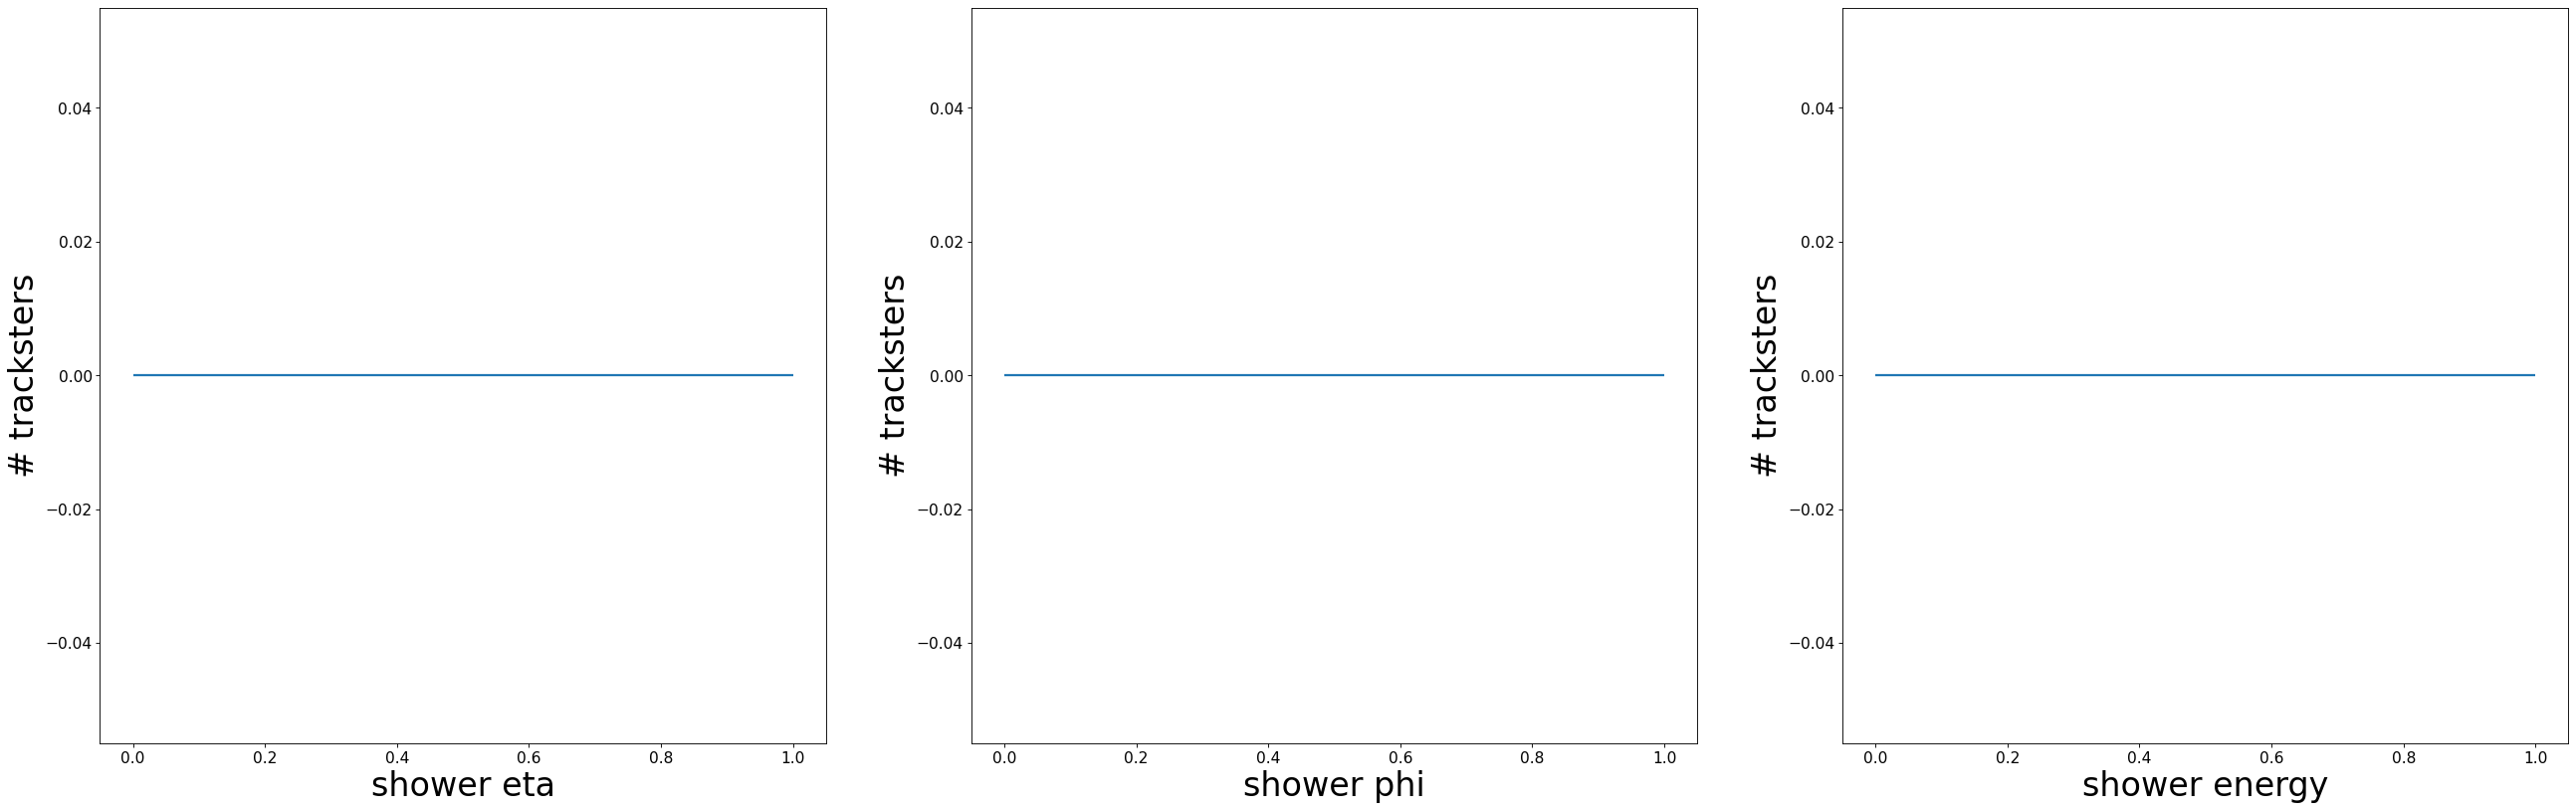

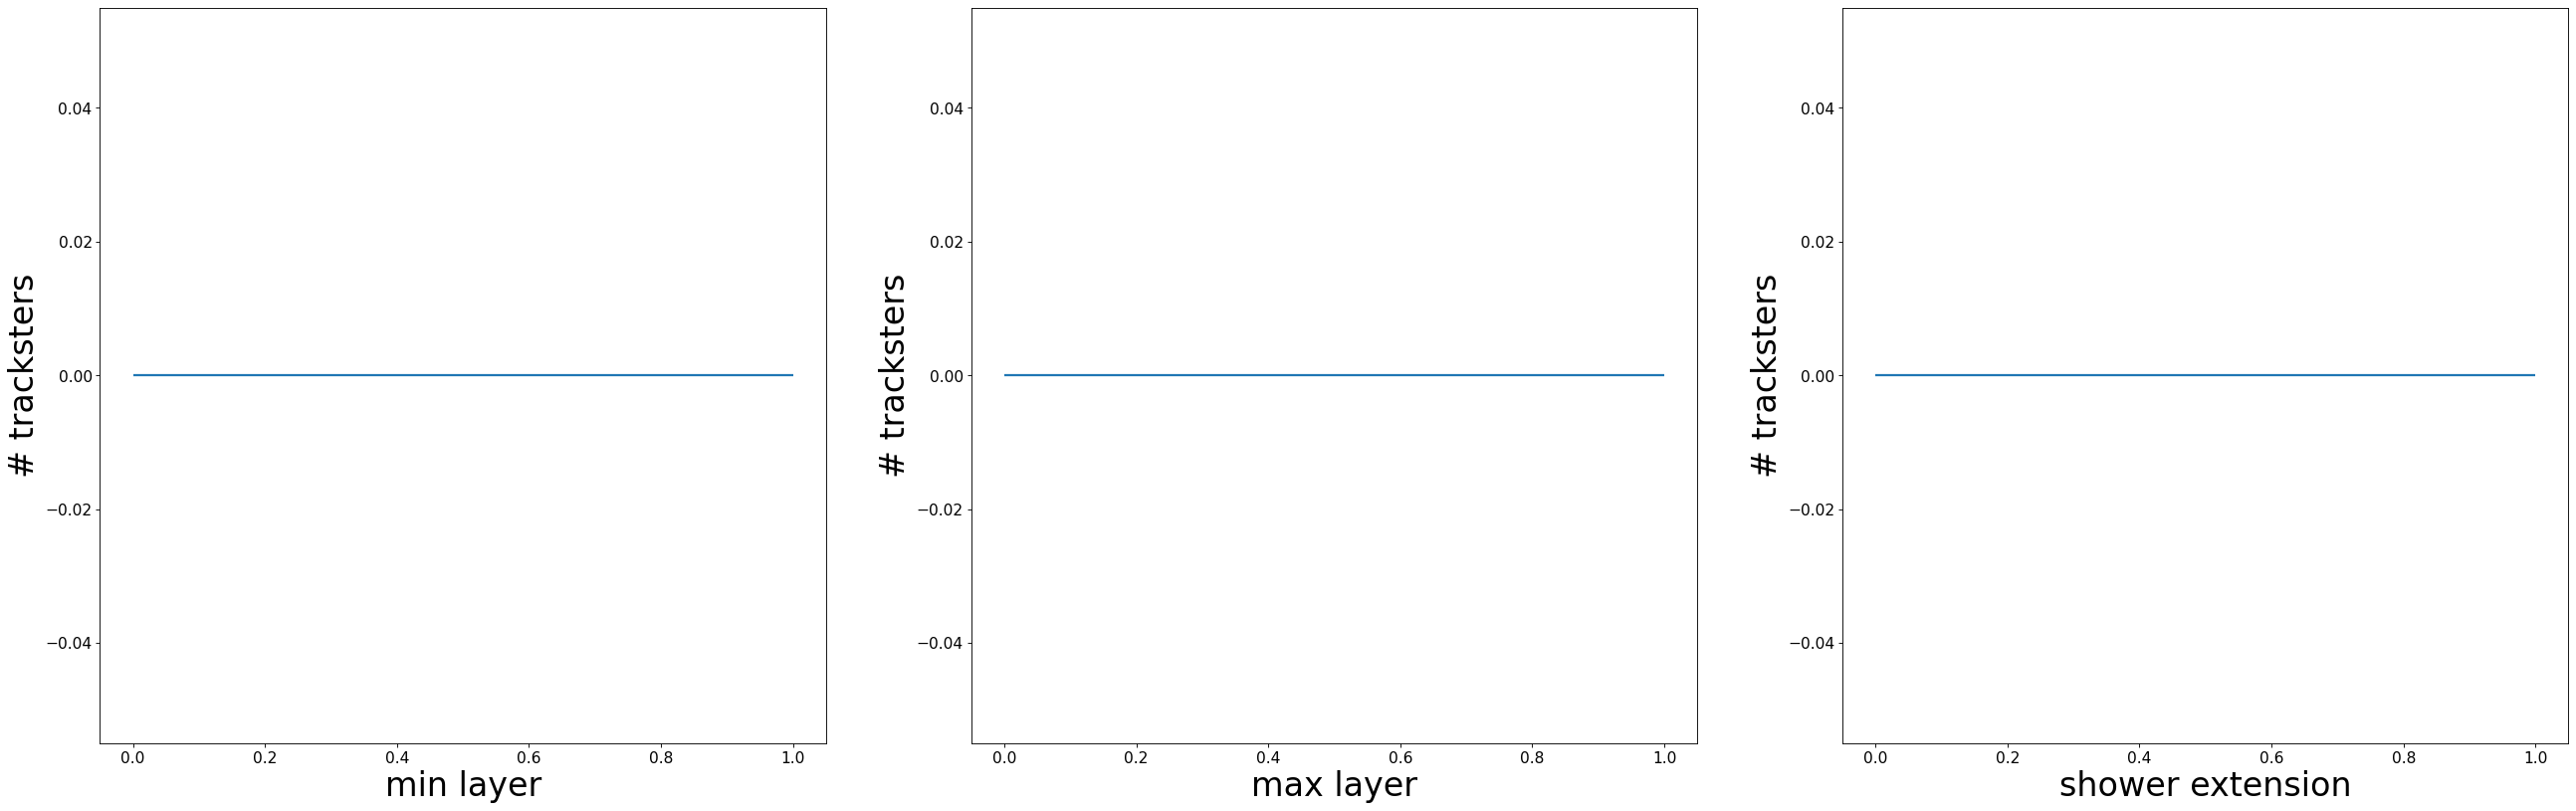

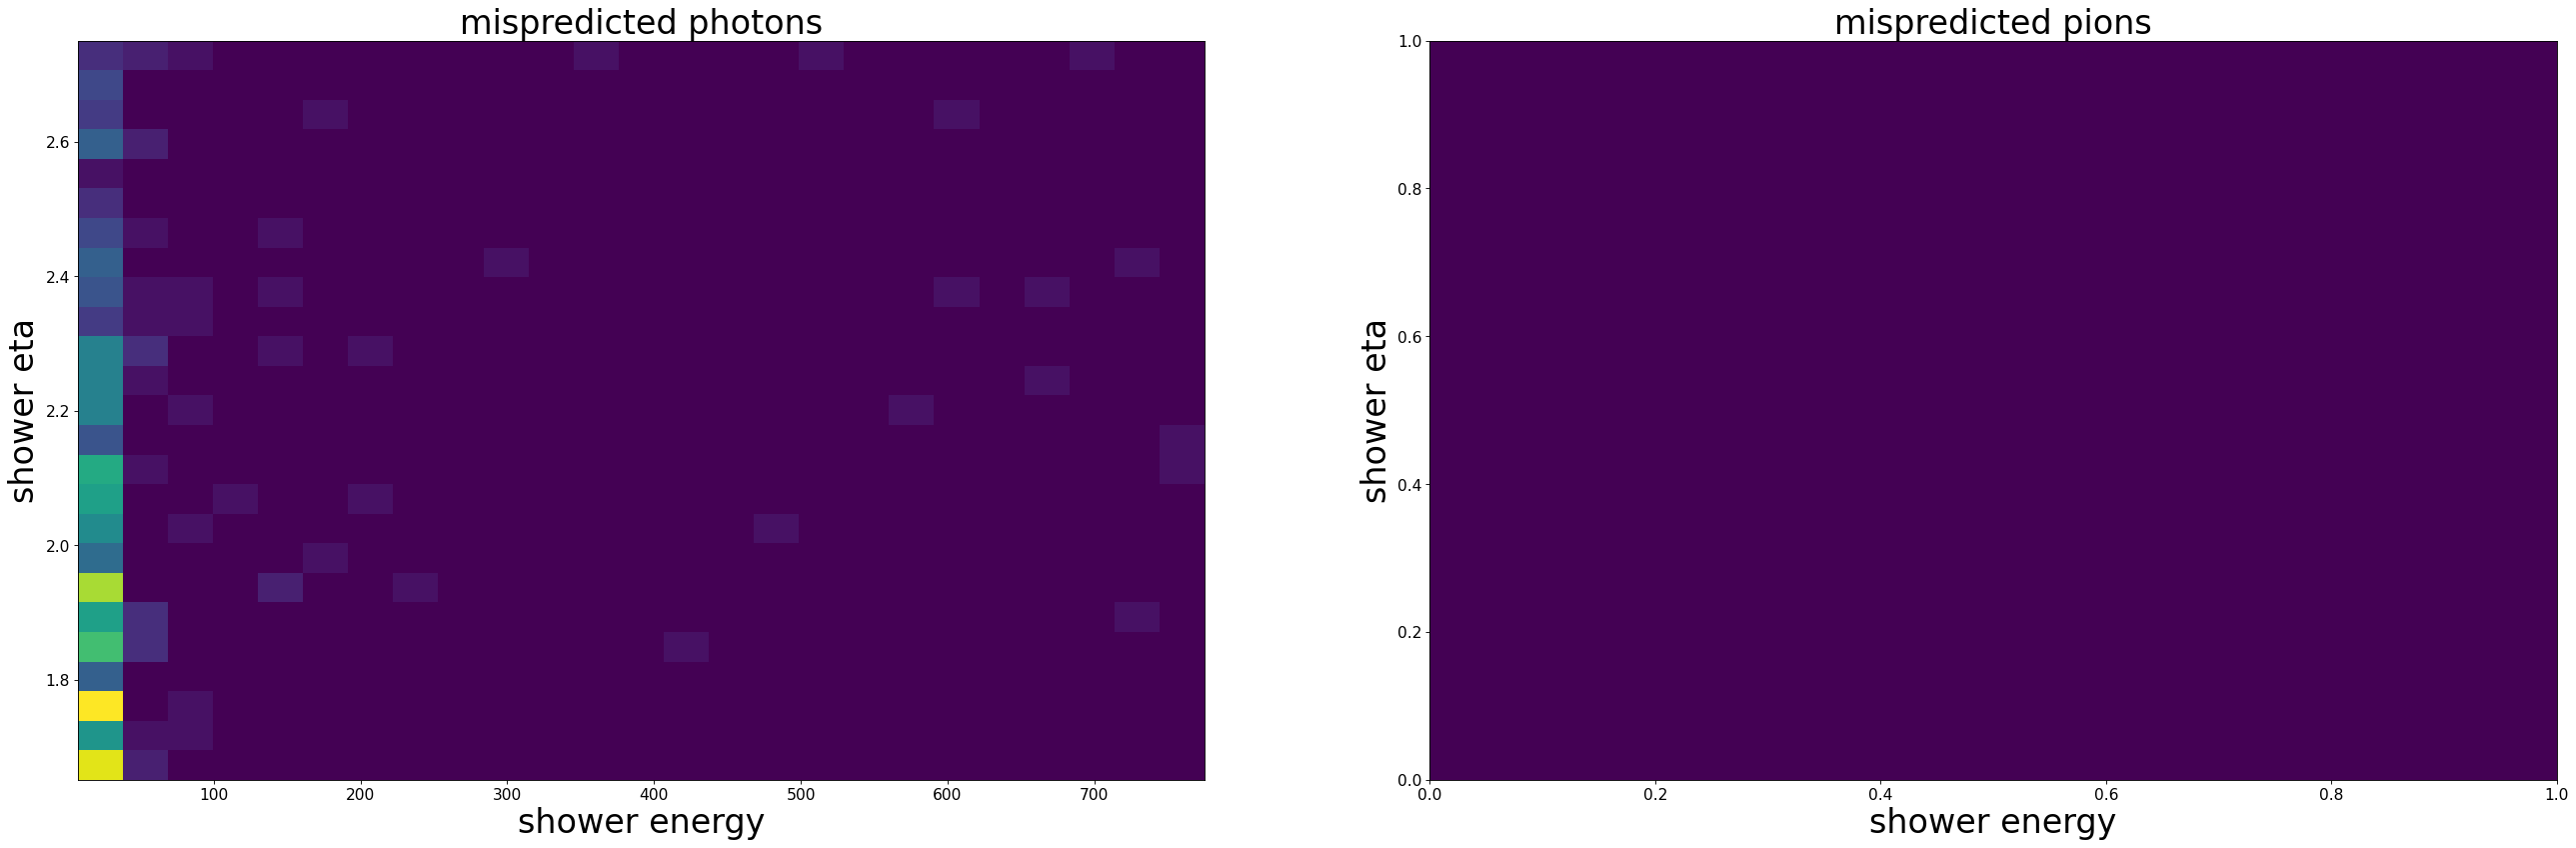

In [26]:
# mispredicted PHOTONS
print("Plot 3D features of mispredicted photons")

# mispredpho_3d is tensor of trackster information with 
# - mispredpho_3d[0] = eta
# - mispredpho_3d[1] = phi
# - mispredpho_3d[2] = energy
# - mispredpho_3d[3] = min layer
# - mispredpho_3d[4] = max layer


eta_mis_pho_3D = []  
phi_mis_pho_3D = []  
en_mis_pho_3D = []
minL_mis_pho_3D = []
maxL_mis_pho_3D = []
ext_mis_pho_3D = [] # shower extension

for tracksterarray in mispredpho_3d:

    eta_mis_pho_3D.append(tracksterarray[0][0])
    phi_mis_pho_3D.append(tracksterarray[0][1])
    en_mis_pho_3D.append(tracksterarray[0][2])
    minL_mis_pho_3D.append(tracksterarray[0][3])
    maxL_mis_pho_3D.append(tracksterarray[0][4])
    ext_mis_pho_3D.append(abs(tracksterarray[0][4] - tracksterarray[0][3]))

print('mispredicted pho:',len(mispredpho_3d))

fig, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
ax0.hist(eta_mis_pho_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax0.set_xlabel('shower eta',fontsize=30)
ax0.set_ylabel('# tracksters',fontsize=30)
ax1.hist(phi_mis_pho_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax1.set_xlabel('shower phi',fontsize=30)
ax1.set_ylabel('# tracksters',fontsize=30)
ax2.hist(en_mis_pho_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax2.set_xlabel('shower energy',fontsize=30)
ax2.set_ylabel('# tracksters',fontsize=30)

plt.show()

fig, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
ax0.hist(minL_mis_pho_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax0.set_xlabel('min layer',fontsize=30)
ax0.set_ylabel('# tracksters',fontsize=30)
ax1.hist(maxL_mis_pho_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax1.set_xlabel('max layer',fontsize=30)
ax1.set_ylabel('# tracksters',fontsize=30)
ax2.hist(ext_mis_pho_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax2.set_xlabel('shower extension',fontsize=30)
ax2.set_ylabel('# tracksters',fontsize=30)
 
plt.show()


# mispredicted PIONS
print("Plot 3D features of mispredicted pions")

# mispredbkg_3d is tensor of trackster information with 
# - mispredbkg_3d[0] = eta
# - mispredbkg_3d[1] = phi
# - mispredbkg_3d[2] = energy
# - mispredbkg_3d[3] = min layer
# - mispredbkg_3d[4] = max layer


eta_mis_bkg_3D = []  
phi_mis_bkg_3D = []  
en_mis_bkg_3D = []
minL_mis_bkg_3D = []
maxL_mis_bkg_3D = []
ext_mis_bkg_3D = [] # shower extension

for tracksterarray in mispredbkg_3d:

    eta_mis_bkg_3D.append(abs(tracksterarray[0][0]))
    phi_mis_bkg_3D.append(tracksterarray[0][1])
    en_mis_bkg_3D.append(tracksterarray[0][2])
    minL_mis_bkg_3D.append(tracksterarray[0][3])
    maxL_mis_bkg_3D.append(tracksterarray[0][4])
    ext_mis_bkg_3D.append(abs(tracksterarray[0][4] - tracksterarray[0][3]))

print('mispredicted bkg:',len(mispredbkg_3d))

fig, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
ax0.hist(eta_mis_bkg_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax0.set_xlabel('shower eta',fontsize=30)
ax0.set_ylabel('# tracksters',fontsize=30)
ax1.hist(phi_mis_bkg_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax1.set_xlabel('shower phi',fontsize=30)
ax1.set_ylabel('# tracksters',fontsize=30)
ax2.hist(en_mis_bkg_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax2.set_xlabel('shower energy',fontsize=30)
ax2.set_ylabel('# tracksters',fontsize=30)

plt.show()

fig, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
ax0.hist(minL_mis_bkg_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax0.set_xlabel('min layer',fontsize=30)
ax0.set_ylabel('# tracksters',fontsize=30)
ax1.hist(maxL_mis_bkg_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax1.set_xlabel('max layer',fontsize=30)
ax1.set_ylabel('# tracksters',fontsize=30)
ax2.hist(ext_mis_bkg_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax2.set_xlabel('shower extension',fontsize=30)
ax2.set_ylabel('# tracksters',fontsize=30)
 
plt.show()

# eta vs energy
fig, (ax0,ax1) = plt.subplots(1, 2,figsize=(40, 12),dpi=80)
ax0.hist2d(en_mis_pho_3D, eta_mis_pho_3D, bins=25)
ax0.set_title('mispredicted photons',fontsize=30)
ax0.set_xlabel('shower energy',fontsize=30)
ax0.set_ylabel('shower eta',fontsize=30)
ax1.hist2d(en_mis_bkg_3D, eta_mis_bkg_3D, bins=25)
ax1.set_title('mispredicted pions',fontsize=30)
ax1.set_xlabel('shower energy',fontsize=30)
ax1.set_ylabel('shower eta',fontsize=30)
plt.show()

#### mispredicted events on test dataset (unbiasloader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95549/95549 [08:27<00:00, 188.18it/s]


threshold 0.99999976
mispred_pho 0


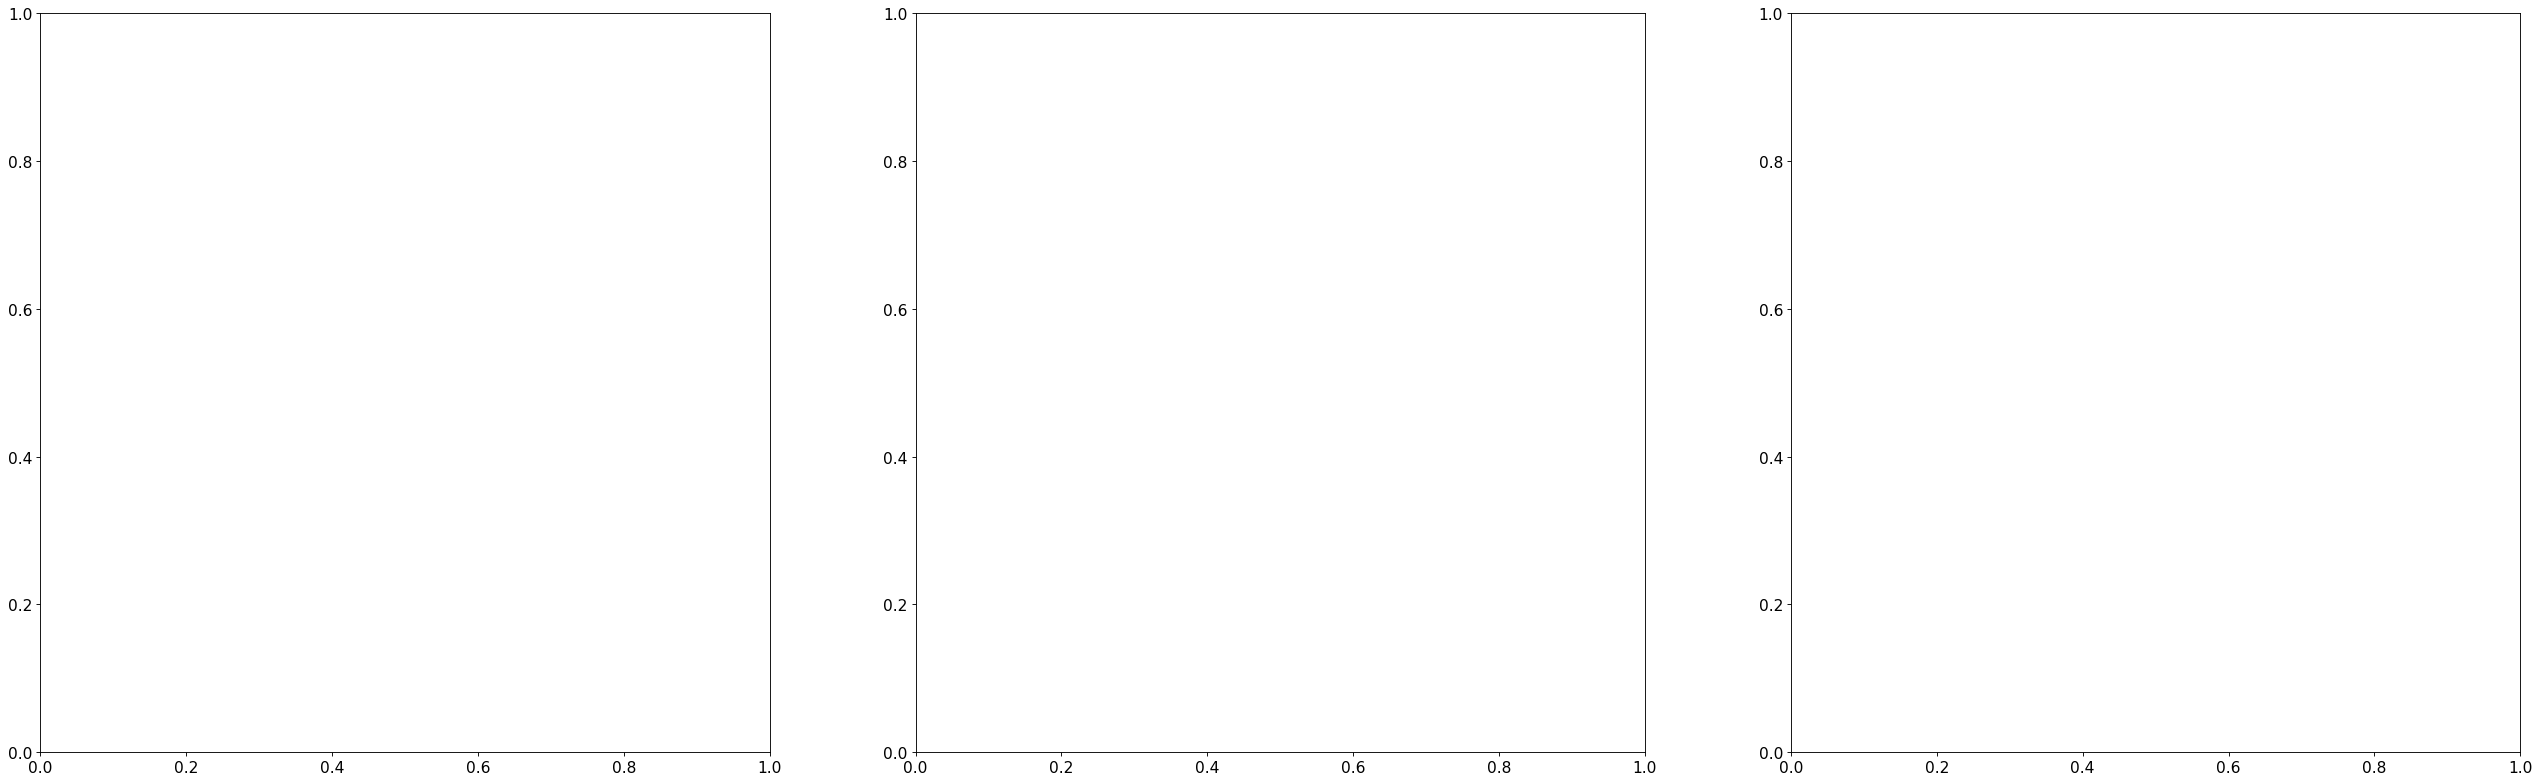

mispred_bkg 10822


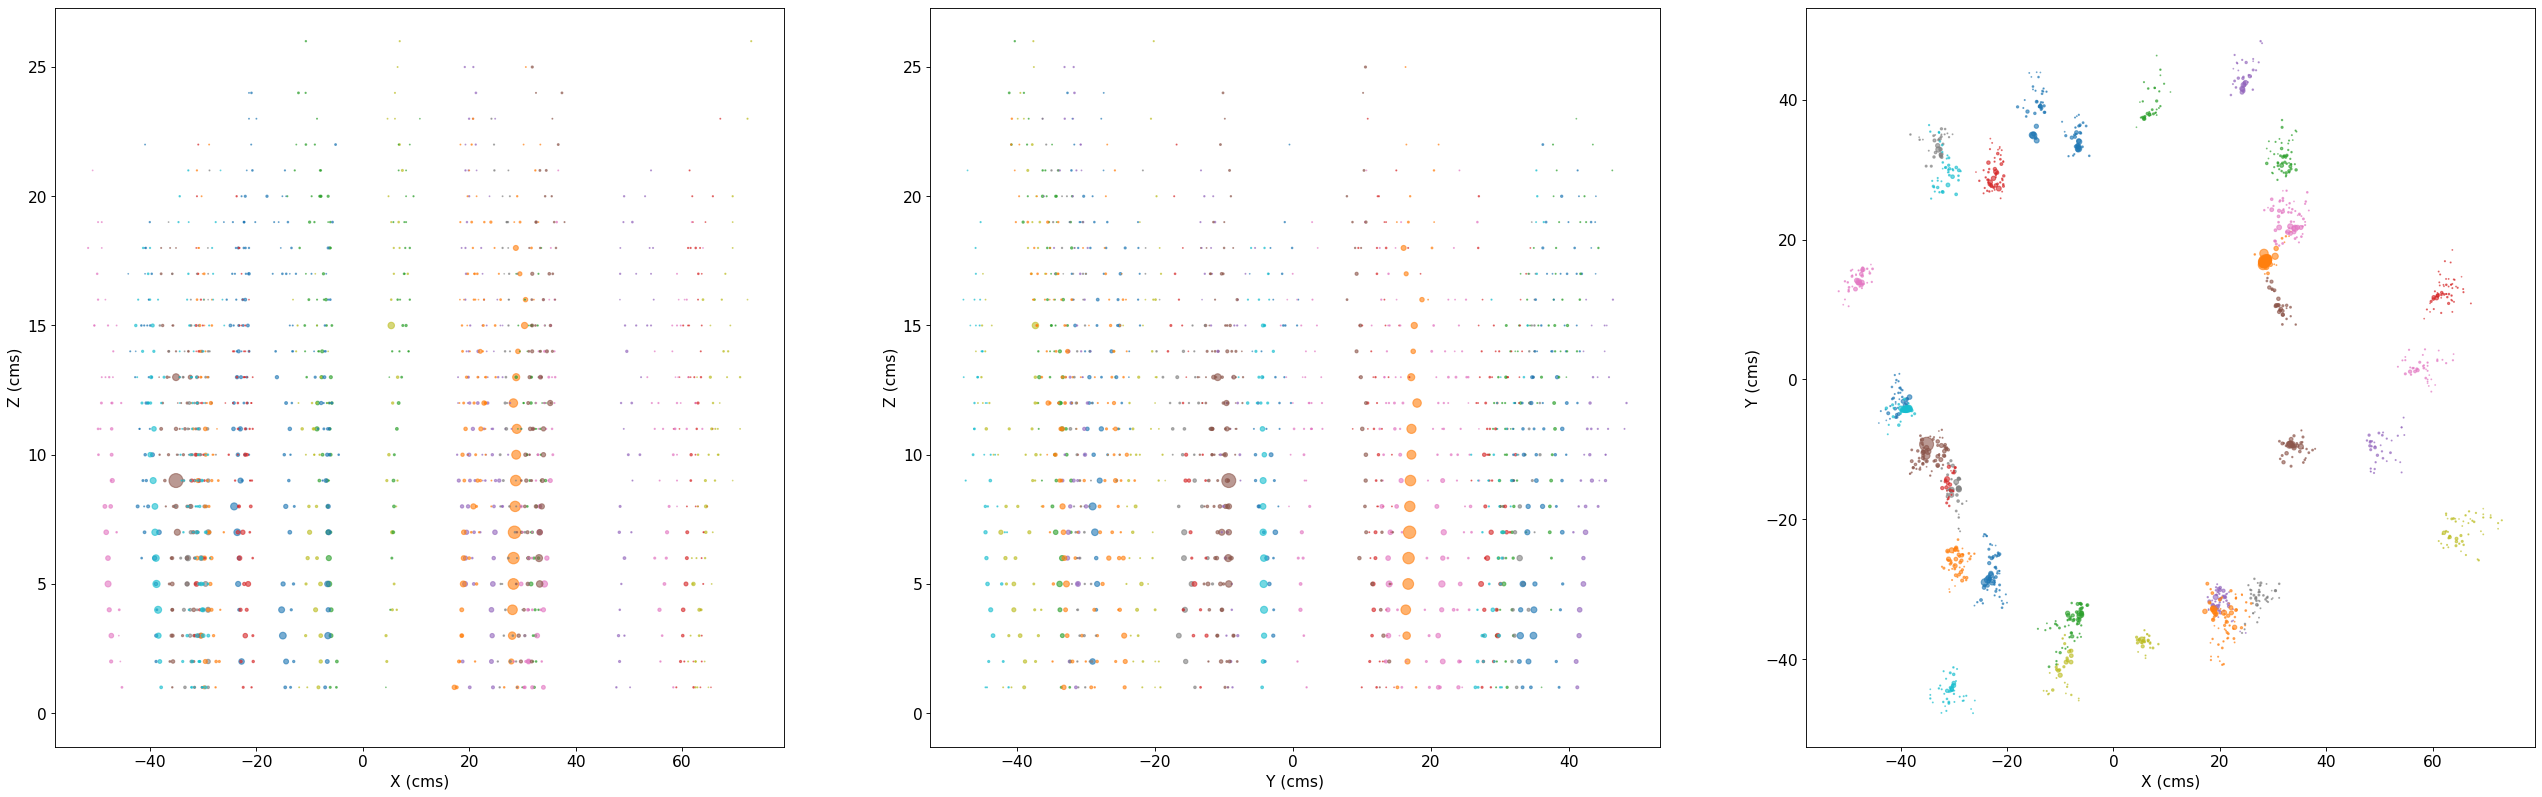

In [27]:
## REMEMBER to specify the threshold (to match the one obtained above)
scores = []
trues = []
true_preds, num_preds = 0., 0.
#threshold90 = threshold90_unbias #0.152
threshold90 = threshold90_tot
mispredpho = []
mispredpho_3d = []
mispredbkg = []
mispredbkg_3d = []

for data in tqdm(unbiasloader): ### change to loaderDNN for DNN
        datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
        #label = label.to(torch.long).squeeze()
        result = model(datax, masks, info3d)
        op = torch.exp(result)[:,1].detach().cpu().flatten().numpy()
        ip = label.detach().cpu().numpy().flatten()
        scores.append(op)
        trues.append( ip )

######## use the following lines if you want to store mispredicted event indices for plotting  (REMEMBER to set batch_size=1)

        opt = np.where(np.hstack(op)>threshold90, 1, 0)
        if (ip == 1)&(opt == 0):
            mispredpho.append(datax.detach().cpu().numpy())
            mispredpho_3d.append(info3d.detach().cpu().numpy()) ## get info of tracksters (3D obj)
        elif (ip == 0)&(opt == 1):
            mispredbkg.append(datax.detach().cpu().numpy())
            mispredbkg_3d.append(info3d.detach().cpu().numpy()) ## get info of tracksters (3D obj)



#Plot mispredicted events:
print("threshold", threshold90)

## mispredicted PHOTONS
fig, (ax0,ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
print("mispred_pho",len(mispredpho))
cc = 0
for uarray in mispredpho:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])
    #uarray = uarray[uarray[:,2]>0]
    ax0.scatter(uarray[:,0],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax0.set_xlabel('X (cms)')
    ax0.set_ylabel('Z (cms)')
    ax1.scatter(uarray[:,1],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax1.set_xlabel('Y (cms)')
    ax1.set_ylabel('Z (cms)')

    ax2.scatter(uarray[:,0],uarray[:,1],s=uarray[:,3]*10,alpha=0.6)
    ax2.set_xlabel('X (cms)')
    ax2.set_ylabel('Y (cms)')
    cc += 1
    if cc > 30:
        break    

plt.show()

## mispredicted PIONS
fig, (ax0,ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
print("mispred_bkg",len(mispredbkg))
cc = 0
for uarray in mispredbkg:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])
    #uarray = uarray[uarray[:,2]>0]
    ax0.scatter(uarray[:,0],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax0.set_xlabel('X (cms)')
    ax0.set_ylabel('Z (cms)')
    ax1.scatter(uarray[:,1],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax1.set_xlabel('Y (cms)')
    ax1.set_ylabel('Z (cms)')

    ax2.scatter(uarray[:,0],uarray[:,1],s=uarray[:,3]*10,alpha=0.6)
    ax2.set_xlabel('X (cms)')
    ax2.set_ylabel('Y (cms)')
    cc += 1
    if cc > 30:
        break    

plt.show()

Plot Barycenter of mispredicted photons
len: 0


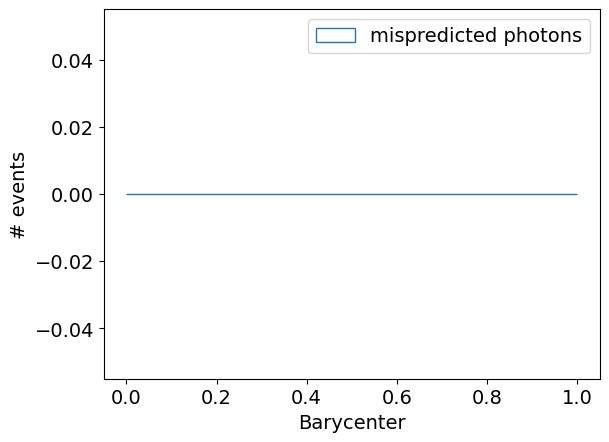

Plot Barycenter of mispredicted pions
len: 10822


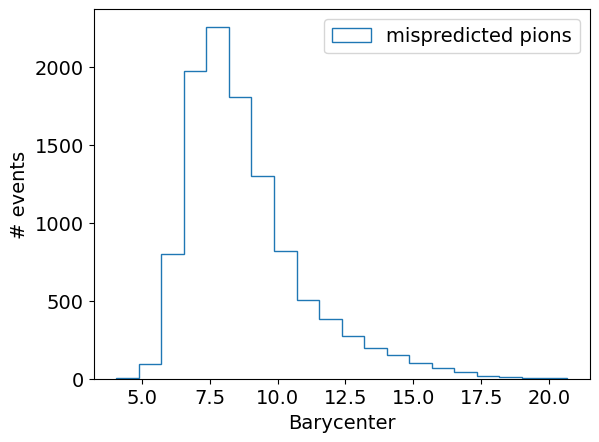

In [28]:
# mispredicted PHOTONS
print("Plot Barycenter of mispredicted photons")

fig, ax = plt.subplots(1,1)#,figsize=(40, 12),dpi=80)

barycenter_mis_pho = []
for uarray in mispredpho:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])

    barycenter_z = np.average(uarray[:,2], weights=uarray[:,3])
    barycenter_mis_pho.append(barycenter_z)
    #print(barycenter_z)

print("len:",len(barycenter_mis_pho))
#print(barycenter_mis_pho)

ax.hist(barycenter_mis_pho, bins=20, histtype='step',linewidth=1,label='mispredicted photons')
ax.legend()
ax.set_xlabel('Barycenter')
ax.set_ylabel('# events')
 
plt.show()


### -------------
# mispredicted PIONS
print("Plot Barycenter of mispredicted pions")

fig, ax = plt.subplots(1,1)#,figsize=(40, 12),dpi=80)

barycenter_mis_bkg = []
for uarray in mispredbkg:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])

    barycenter_z = np.average(uarray[:,2], weights=uarray[:,3])
    barycenter_mis_bkg.append(barycenter_z)
    #print(barycenter_z)

print("len:",len(barycenter_mis_bkg))
#print(barycenter_mis_pho)

ax.hist(barycenter_mis_bkg, bins=20, histtype='step',linewidth=1,label='mispredicted pions')
ax.legend()
ax.set_xlabel('Barycenter')
ax.set_ylabel('# events')
 

plt.show()

Plot 3D features of mispredicted photons
mispredicted pho: 0


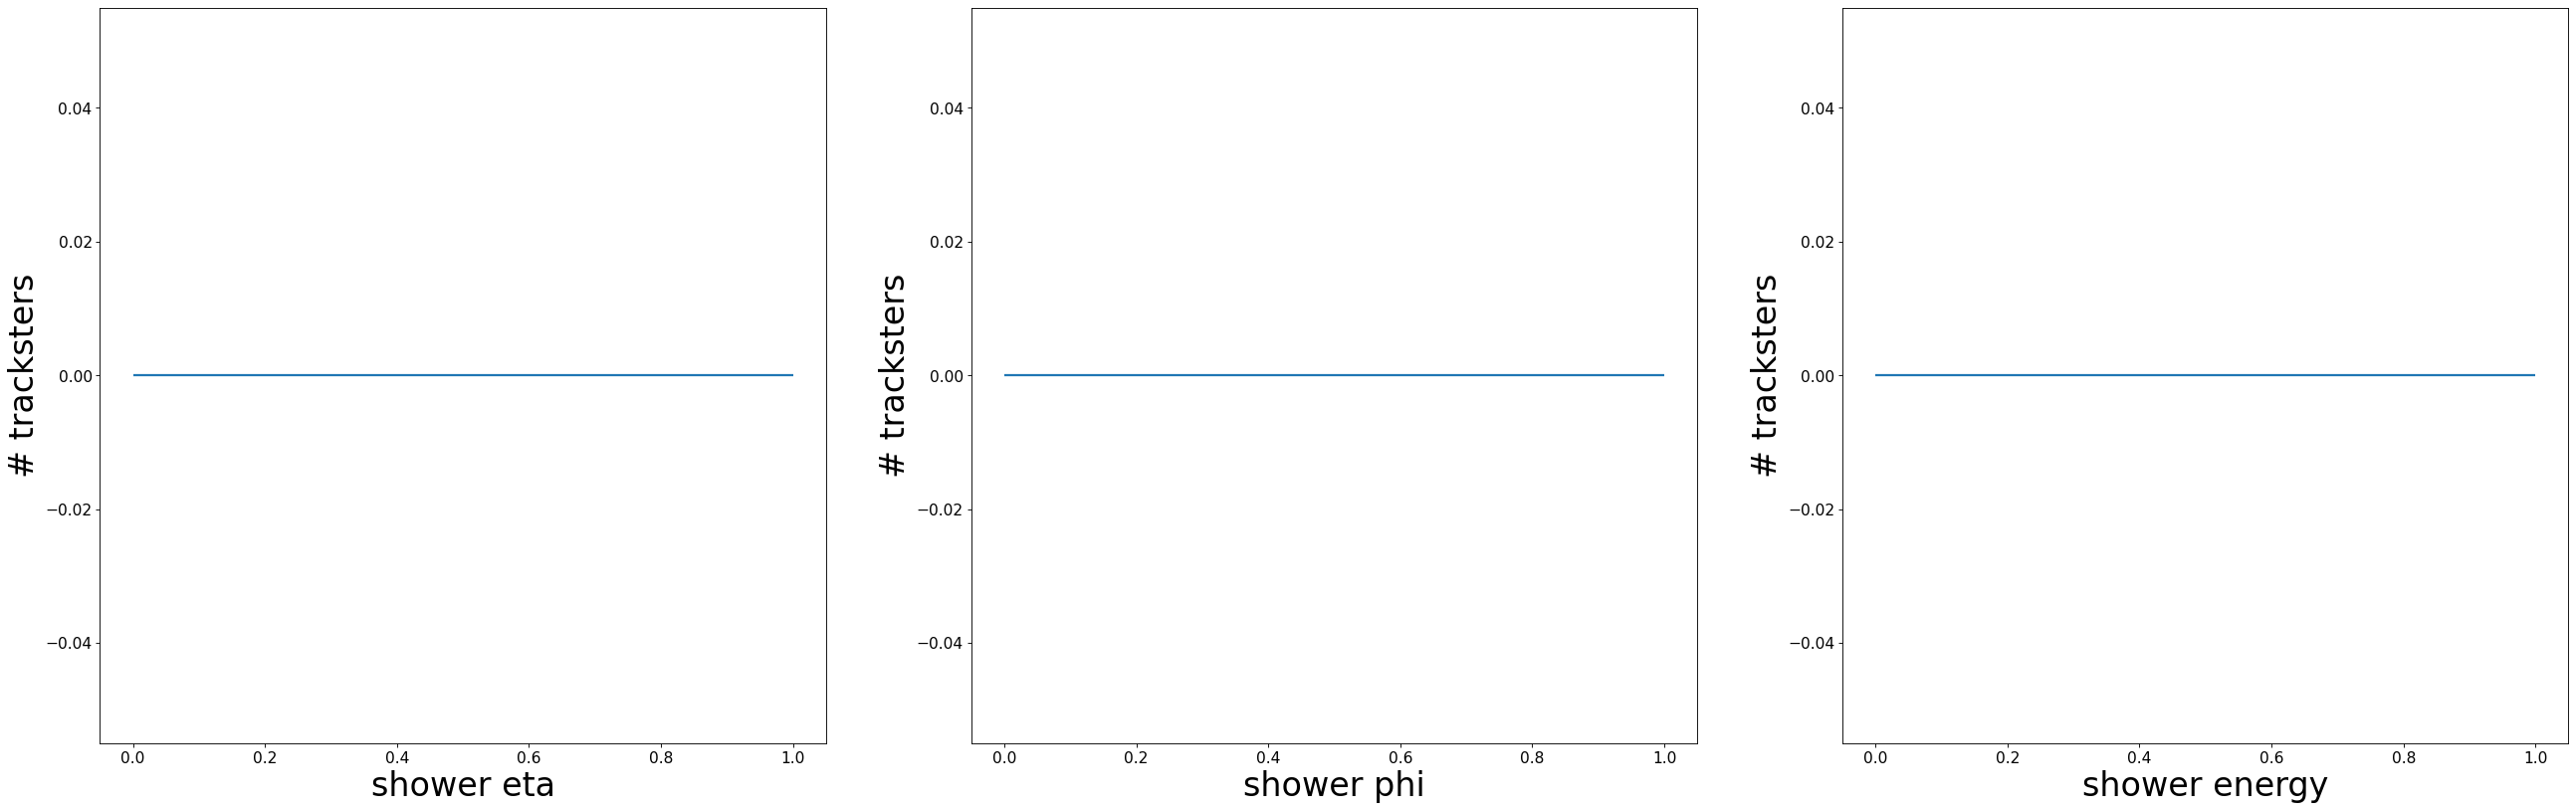

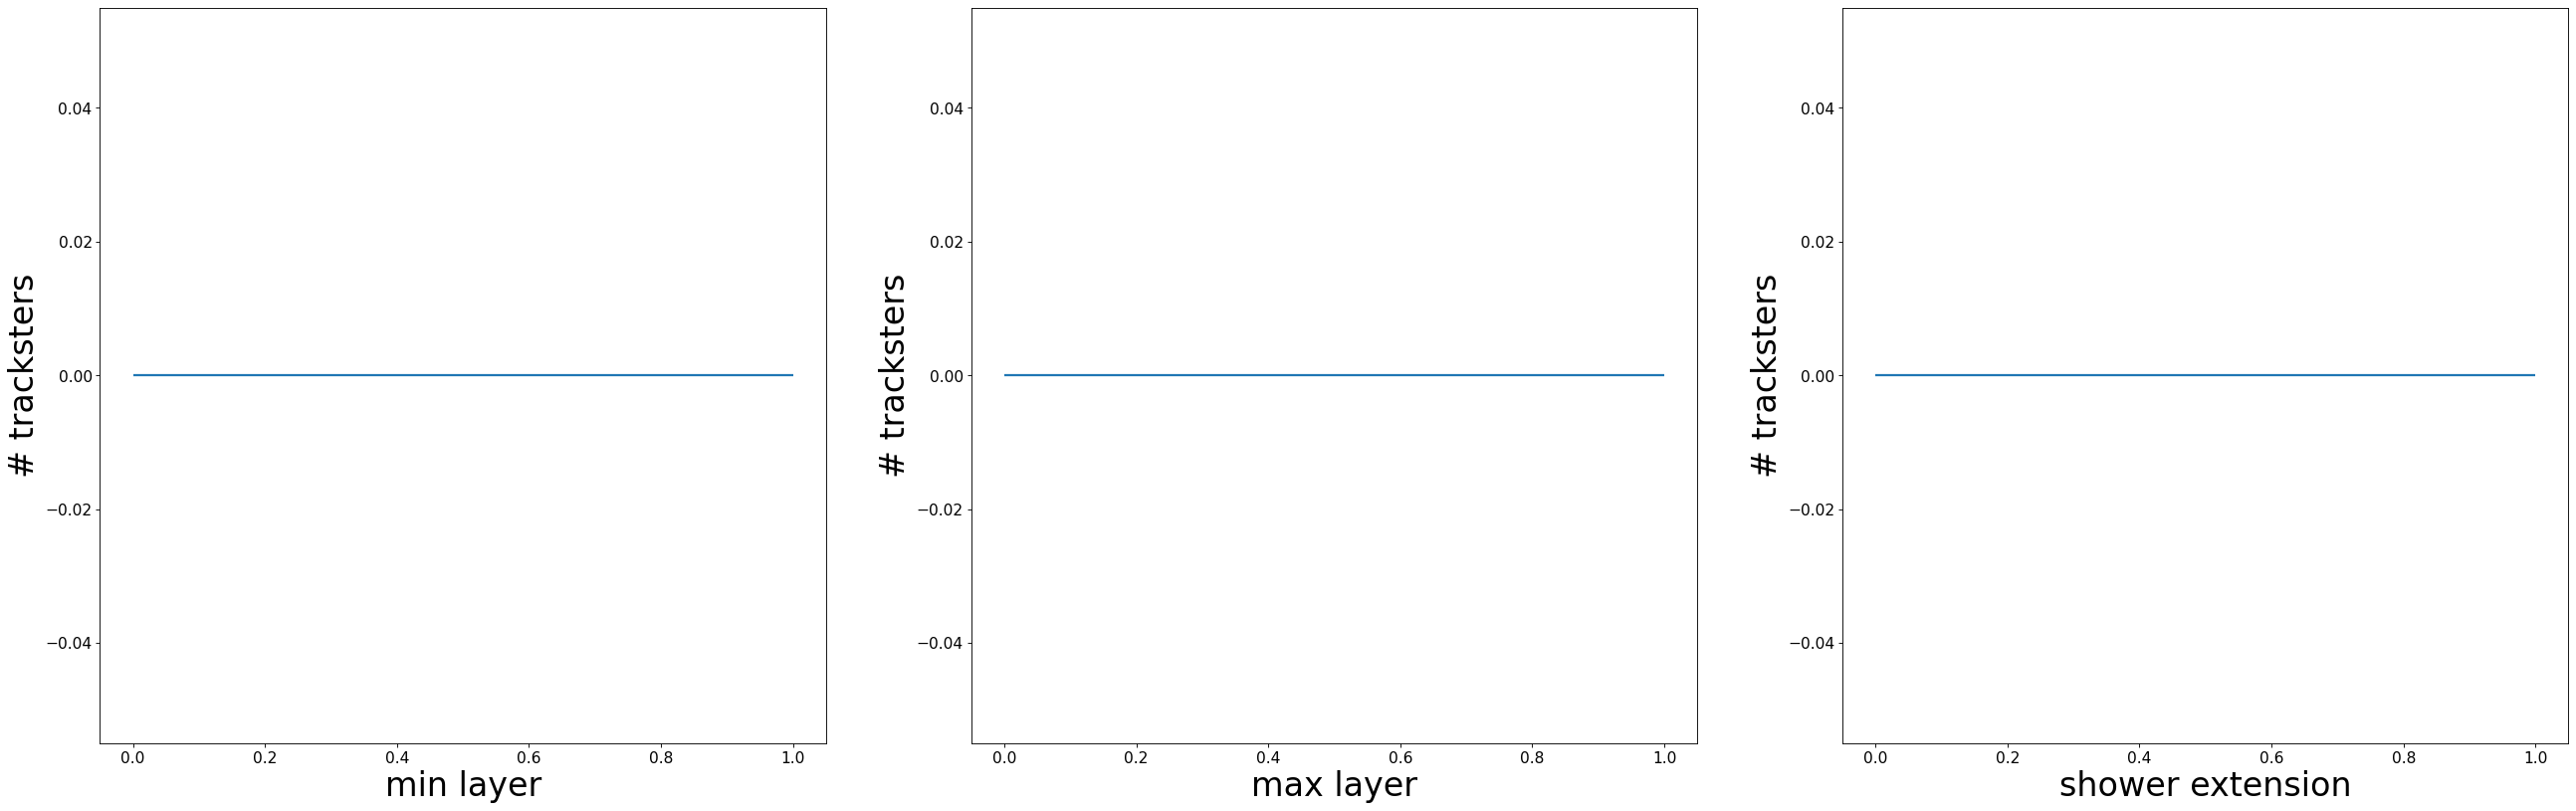

Plot 3D features of mispredicted pions
mispredicted bkg: 10822


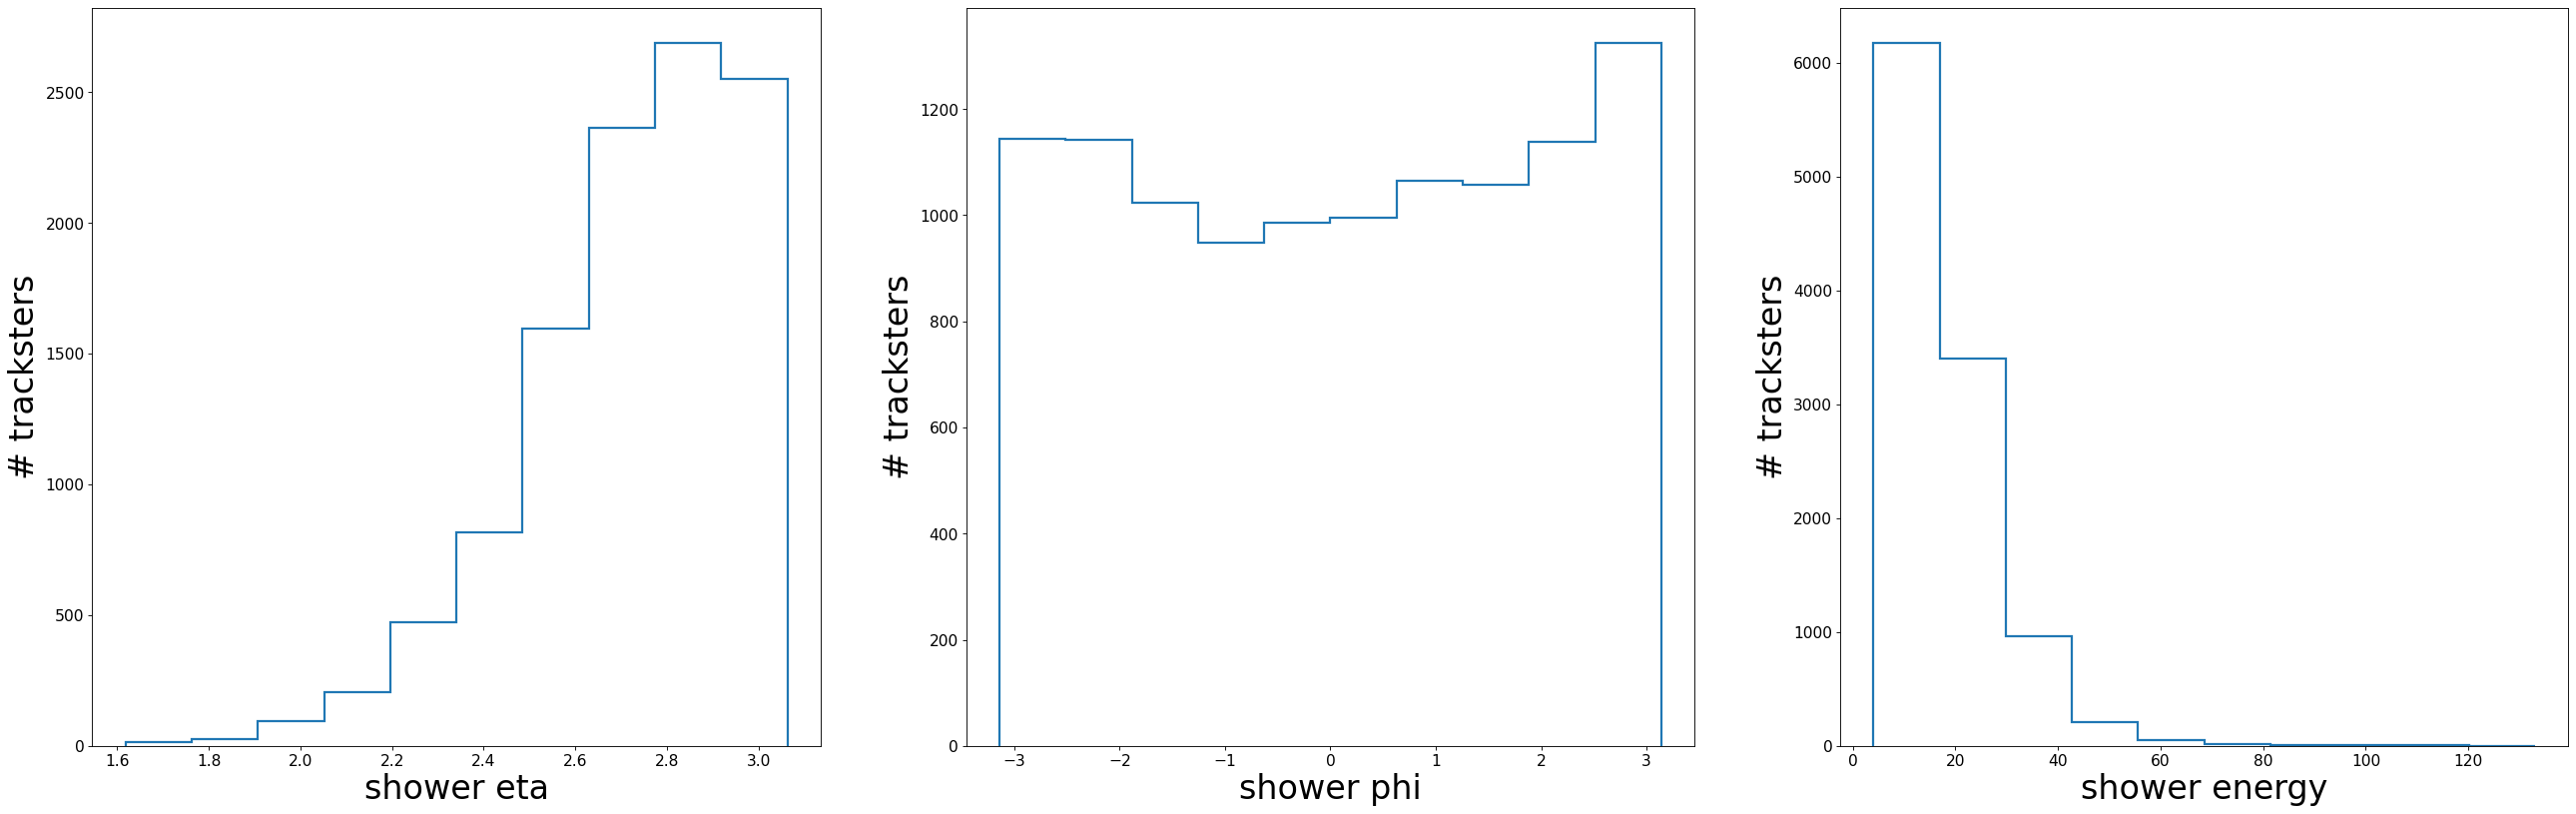

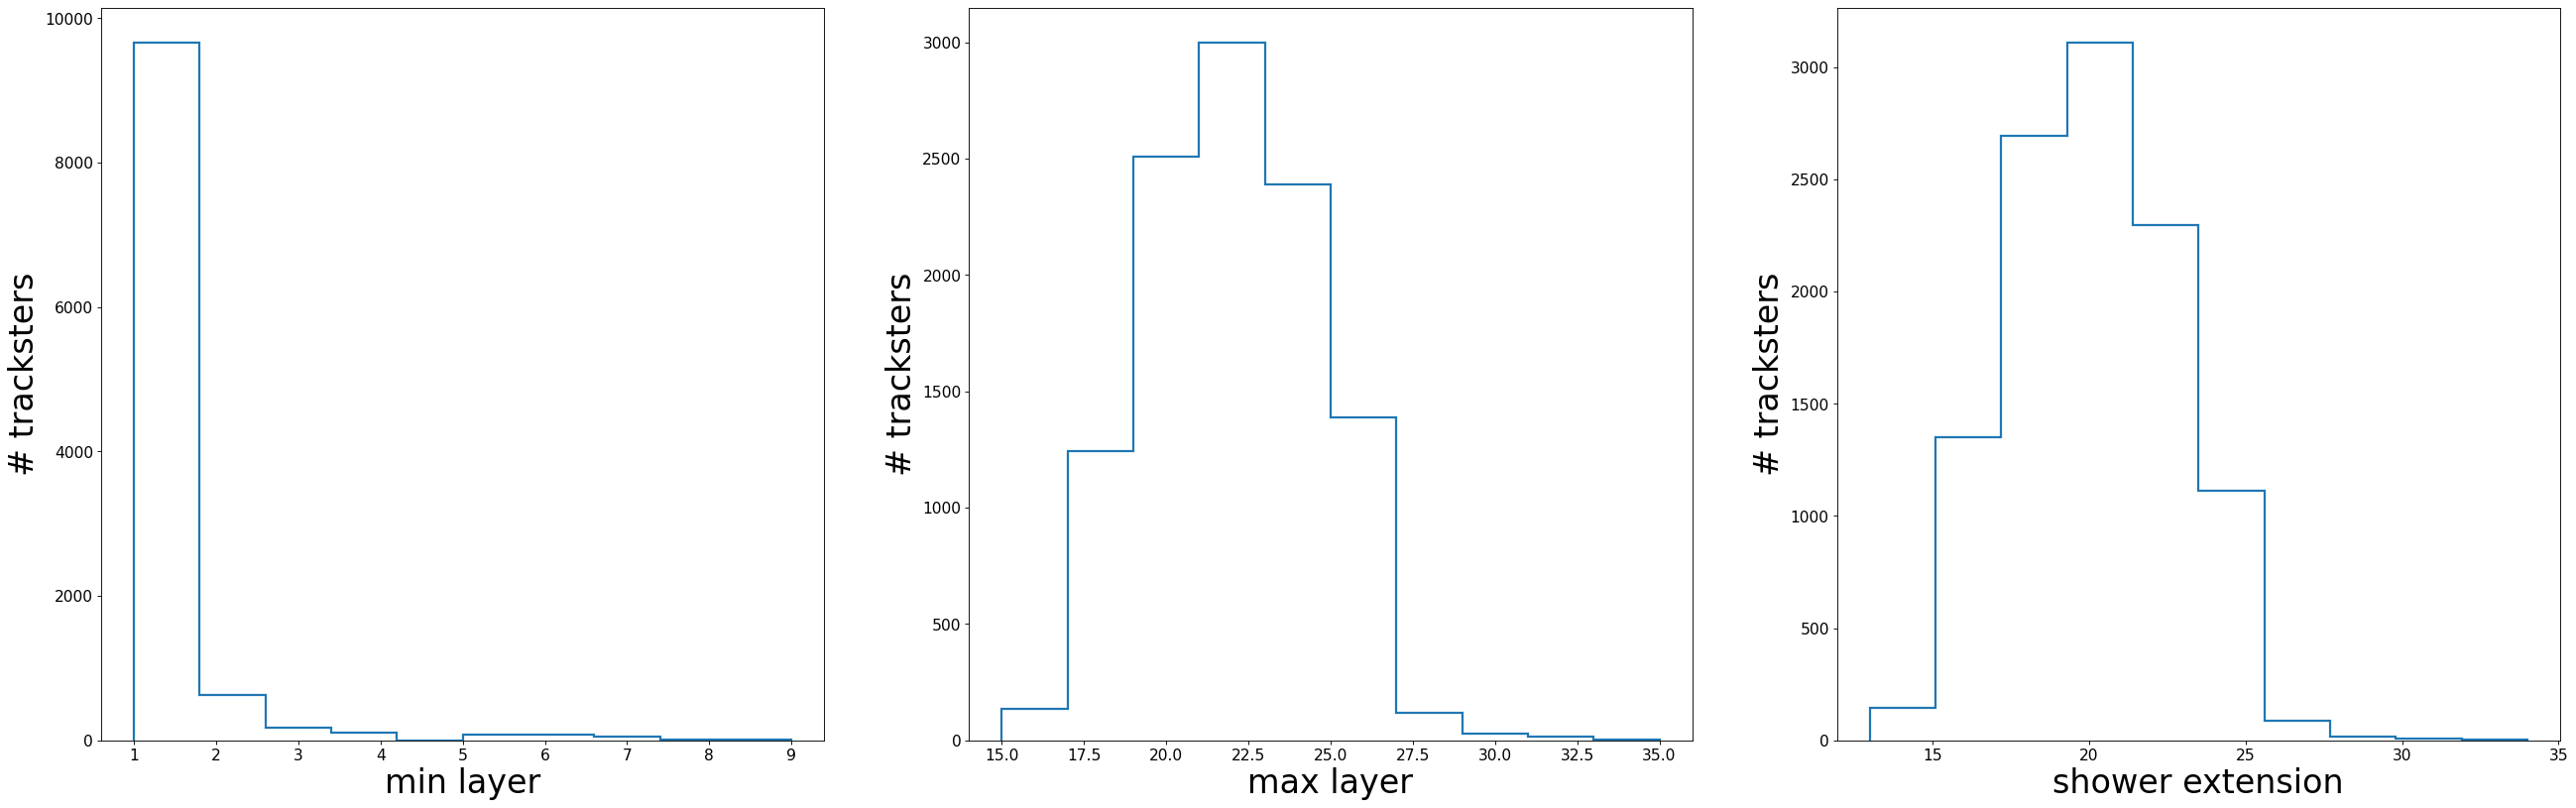

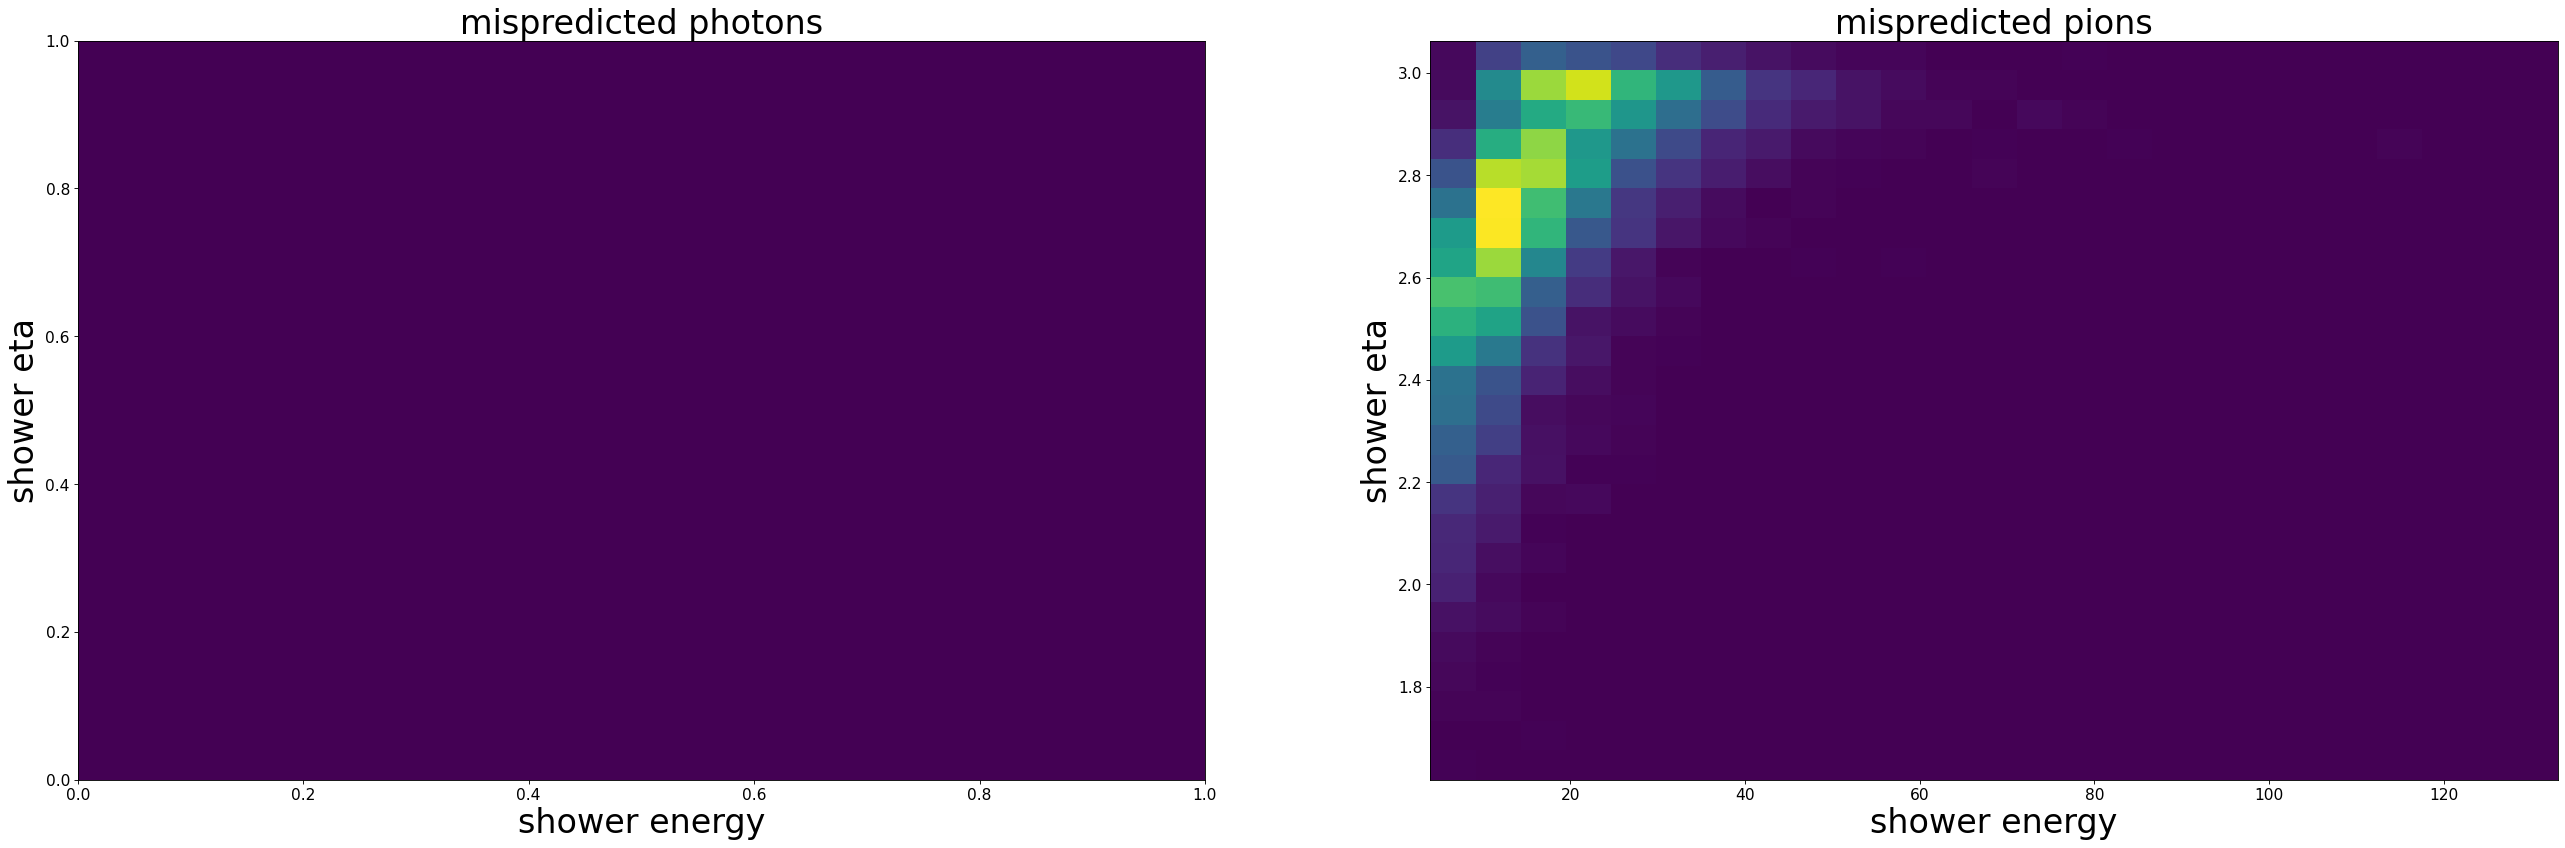

In [29]:
# mispredicted PHOTONS
print("Plot 3D features of mispredicted photons")

# mispredpho_3d is tensor of trackster information with 
# - mispredpho_3d[0] = eta
# - mispredpho_3d[1] = phi
# - mispredpho_3d[2] = energy
# - mispredpho_3d[3] = min layer
# - mispredpho_3d[4] = max layer


eta_mis_pho_3D = []  
phi_mis_pho_3D = []  
en_mis_pho_3D = []
minL_mis_pho_3D = []
maxL_mis_pho_3D = []
ext_mis_pho_3D = [] # shower extension

for tracksterarray in mispredpho_3d:

    eta_mis_pho_3D.append(tracksterarray[0][0])
    phi_mis_pho_3D.append(tracksterarray[0][1])
    en_mis_pho_3D.append(tracksterarray[0][2])
    minL_mis_pho_3D.append(tracksterarray[0][3])
    maxL_mis_pho_3D.append(tracksterarray[0][4])
    ext_mis_pho_3D.append(abs(tracksterarray[0][4] - tracksterarray[0][3]))

print('mispredicted pho:',len(mispredpho_3d))

fig, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
ax0.hist(eta_mis_pho_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax0.set_xlabel('shower eta',fontsize=30)
ax0.set_ylabel('# tracksters',fontsize=30)
ax1.hist(phi_mis_pho_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax1.set_xlabel('shower phi',fontsize=30)
ax1.set_ylabel('# tracksters',fontsize=30)
ax2.hist(en_mis_pho_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax2.set_xlabel('shower energy',fontsize=30)
ax2.set_ylabel('# tracksters',fontsize=30)

plt.show()

fig, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
ax0.hist(minL_mis_pho_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax0.set_xlabel('min layer',fontsize=30)
ax0.set_ylabel('# tracksters',fontsize=30)
ax1.hist(maxL_mis_pho_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax1.set_xlabel('max layer',fontsize=30)
ax1.set_ylabel('# tracksters',fontsize=30)
ax2.hist(ext_mis_pho_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax2.set_xlabel('shower extension',fontsize=30)
ax2.set_ylabel('# tracksters',fontsize=30)
 
plt.show()


# mispredicted PIONS
print("Plot 3D features of mispredicted pions")

# mispredbkg_3d is tensor of trackster information with 
# - mispredbkg_3d[0] = eta
# - mispredbkg_3d[1] = phi
# - mispredbkg_3d[2] = energy
# - mispredbkg_3d[3] = min layer
# - mispredbkg_3d[4] = max layer


eta_mis_bkg_3D = []  
phi_mis_bkg_3D = []  
en_mis_bkg_3D = []
minL_mis_bkg_3D = []
maxL_mis_bkg_3D = []
ext_mis_bkg_3D = [] # shower extension

for tracksterarray in mispredbkg_3d:

    eta_mis_bkg_3D.append(abs(tracksterarray[0][0]))
    phi_mis_bkg_3D.append(tracksterarray[0][1])
    en_mis_bkg_3D.append(tracksterarray[0][2])
    minL_mis_bkg_3D.append(tracksterarray[0][3])
    maxL_mis_bkg_3D.append(tracksterarray[0][4])
    ext_mis_bkg_3D.append(abs(tracksterarray[0][4] - tracksterarray[0][3]))

print('mispredicted bkg:',len(mispredbkg_3d))

fig, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
ax0.hist(eta_mis_bkg_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax0.set_xlabel('shower eta',fontsize=30)
ax0.set_ylabel('# tracksters',fontsize=30)
ax1.hist(phi_mis_bkg_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax1.set_xlabel('shower phi',fontsize=30)
ax1.set_ylabel('# tracksters',fontsize=30)
ax2.hist(en_mis_bkg_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax2.set_xlabel('shower energy',fontsize=30)
ax2.set_ylabel('# tracksters',fontsize=30)

plt.show()

fig, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
ax0.hist(minL_mis_bkg_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax0.set_xlabel('min layer',fontsize=30)
ax0.set_ylabel('# tracksters',fontsize=30)
ax1.hist(maxL_mis_bkg_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax1.set_xlabel('max layer',fontsize=30)
ax1.set_ylabel('# tracksters',fontsize=30)
ax2.hist(ext_mis_bkg_3D, histtype='step', linewidth=2, label='mispredicted photons')
ax2.set_xlabel('shower extension',fontsize=30)
ax2.set_ylabel('# tracksters',fontsize=30)
 
plt.show()

# eta vs energy
fig, (ax0,ax1) = plt.subplots(1, 2,figsize=(40, 12),dpi=80)
ax0.hist2d(en_mis_pho_3D, eta_mis_pho_3D, bins=25)
ax0.set_title('mispredicted photons',fontsize=30)
ax0.set_xlabel('shower energy',fontsize=30)
ax0.set_ylabel('shower eta',fontsize=30)
ax1.hist2d(en_mis_bkg_3D, eta_mis_bkg_3D, bins=25)
ax1.set_title('mispredicted pions',fontsize=30)
ax1.set_xlabel('shower energy',fontsize=30)
ax1.set_ylabel('shower eta',fontsize=30)
plt.show()